In [2]:
import logging
import os
import sys
from pathlib import Path
from typing import Tuple
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from vbase_utils.stats.pit_robust_betas import pit_robust_betas
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [3]:
import pandas as pd
etf_list = pd.read_csv("_____ETF___.csv")
etf_list = etf_list.drop_duplicates(subset='ETF Ticker', keep='first')
value_etf = etf_list[etf_list['스타일'] == "가치주 (Value)"].loc[:,'ETF Ticker'].to_list()
growth_etf = etf_list[etf_list['스타일'] == "성장주 (Growth)"].loc[:,'ETF Ticker'].to_list()
dividend_etf = etf_list[etf_list['스타일'] == "고배당 (High Dividend)"].loc[:,'ETF Ticker'].to_list()
small_etf = etf_list[etf_list['스타일'] == "소형주 (Small Cap)"].loc[:,'ETF Ticker'].to_list()
mid_etf = etf_list[etf_list['스타일'] == "중형주 (Mid Cap)"].loc[:,'ETF Ticker'].to_list()
large_etf = etf_list[etf_list['스타일'] == "대형주 (Large Cap)"].loc[:,'ETF Ticker'].to_list()
mid_etf.remove('IJH')
etf_assortment = [value_etf,growth_etf,dividend_etf,small_etf,mid_etf,large_etf]
etf_types = 'value_etf,growth_etf,dividend_etf,small_etf,mid_etf,large_etf'.split(',')

In [4]:
etf_list.groupby('스타일').count() # groupby "Style" (is translated to 스타일 in Korean)

,ETF Ticker
스타일,
가치주 (Value),17
고배당 (High Dividend),7
대형주 (Large Cap),5
모멘텀 (Momentum),1
성장주 (Growth),13
소형주 (Small Cap),8
스마트 베타,5
중형주 (Mid Cap),10


In [5]:

etf_assortment

[['RPV',
  'VOE',
  'VBR',
  'IWD',
  'IWS',
  'IWN',
  'IWX',
  'IUSV',
  'DTH',
  'EFV',
  'FDL',
  'FTA',
  'DON',
  'PID',
  'PFM',
  'PXF',
  'PWV'],
 ['RPG',
  'VUG',
  'VBK',
  'IVW',
  'IWO',
  'IWP',
  'IUSG',
  'SCHG',
  'SPYG',
  'EPS',
  'FAD',
  'FTC',
  'FTCS'],
 ['VYM', 'SDY', 'DHS', 'DVY', 'PEY', 'FVD', 'DEW'],
 ['IJS', 'PRFZ', 'RZV', 'RZG', 'FYX', 'DFE', 'DLS', 'DWX'],
 ['VOT', 'MDYV', 'MDYG', 'IJK', 'IJT', 'FNX', 'RWK', 'RFG', 'RFV'],
 ['SPHQ', 'IWF', 'DLN', 'DTD', 'FEX']]

In [6]:
etf_data = []
for etf_as in etf_assortment:
    etf_data += etf_as

In [7]:
etf_data



['RPV',
 'VOE',
 'VBR',
 'IWD',
 'IWS',
 'IWN',
 'IWX',
 'IUSV',
 'DTH',
 'EFV',
 'FDL',
 'FTA',
 'DON',
 'PID',
 'PFM',
 'PXF',
 'PWV',
 'RPG',
 'VUG',
 'VBK',
 'IVW',
 'IWO',
 'IWP',
 'IUSG',
 'SCHG',
 'SPYG',
 'EPS',
 'FAD',
 'FTC',
 'FTCS',
 'VYM',
 'SDY',
 'DHS',
 'DVY',
 'PEY',
 'FVD',
 'DEW',
 'IJS',
 'PRFZ',
 'RZV',
 'RZG',
 'FYX',
 'DFE',
 'DLS',
 'DWX',
 'VOT',
 'MDYV',
 'MDYG',
 'IJK',
 'IJT',
 'FNX',
 'RWK',
 'RFG',
 'RFV',
 'SPHQ',
 'IWF',
 'DLN',
 'DTD',
 'FEX']

In [8]:
etf_list['ETF Ticker'].unique()

array(['RPV', 'VOE', 'VBR', 'IWD', 'IWS', 'IWN', 'IWX', 'IUSV', 'DTH',
       'EFV', 'FDL', 'FTA', 'DON', 'PID', 'PFM', 'PXF', 'PWV', 'RPG',
       'VUG', 'VBK', 'IVW', 'IWO', 'IWP', 'IUSG', 'SCHG', 'SPYG', 'EPS',
       'FAD', 'FTC', 'FTCS', 'VYM', 'SDY', 'DHS', 'DVY', 'PEY', 'FVD',
       'DEW', 'IJS', 'PRFZ', 'RZV', 'RZG', 'FYX', 'DFE', 'DLS', 'DWX',
       'VOT', 'MDYV', 'MDYG', 'IJK', 'IJH', 'IJT', 'FNX', 'RWK', 'RFG',
       'RFV', 'SPHQ', 'IWF', 'DLN', 'DTD', 'FEX', 'PDP', 'RSP', 'PRN',
       'PTH', 'PWB', 'PUI'], dtype=object)

In [9]:
etf_list

,스타일,ETF Ticker
0,가치주 (Value),RPV
1,가치주 (Value),VOE
2,가치주 (Value),VBR
3,가치주 (Value),IWD
4,가치주 (Value),IWS
...,...,...
76,스마트 베타,RSP
81,스마트 베타,PRN
82,스마트 베타,PTH
83,스마트 베타,PWB


In [10]:
import yfinance as yf
irx = yf.download("^IRX", start="2010-01-01", end="2025-12-31")
irx = irx['Close']['^IRX']
rf_daily = ((1 + irx / 100) ** (1 / 252)) - 1
rf_daily.name = 'rf_daily'

/var/folders/6x/xp45m8ws0zj3yl7vwtwgbs8c0000gn/T/ipykernel_43636/99418034.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  irx = yf.download("^IRX", start="2010-01-01", end="2025-12-31")
[*********************100%***********************]  1 of 1 completed


In [11]:
def plot_cumulative_residuals(
    residuals: pd.DataFrame, title: str, figsize: Tuple[int, int] = (15, 8)
) -> None:
    """Plot cumulative residuals for a set of assets.

    Args:
        residuals: DataFrame of residuals to plot.
        title: Title for the plot.
        figsize: Figure size as (width, height).
    """
    cum_residuals = (1 + residuals).cumprod() - 1

    plt.figure(figsize=figsize)
    for col in cum_residuals.columns:
        plt.plot(cum_residuals.index, cum_residuals[col], label=col)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Residual Return")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
df_russel_rets = pd.read_csv("data/russel_etf_returns.csv",
    index_col=0,
    parse_dates=True,
)
df_rets = pd.read_csv(
                 "data/final_df_rets.csv",
    index_col=0,
    parse_dates=True,
)
df_rets.drop('ALTS', axis = 1, inplace = True)
weekly_rebalance_new = pd.DatetimeIndex([dt for dt in df_rets.index if dt.weekday() == 4])

In [13]:
cumul_etf = []
for i in etf_assortment:
    cumul_etf += i
# cumul_etf += ['XBI', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
df_rets[cumul_etf]


,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.009091,0.003110,-0.001081,0.005980,0.008258,-0.003693,0.014363,0.005222,0.003608,0.006376,...,0.001544,0.003428,0.004904,0.006750,0.004869,0.006167,0.000198,-0.000718,-0.001195,0.001708
2010-01-06,0.009009,0.007086,0.001623,0.003398,0.003699,-0.002022,0.000000,0.003247,-0.003146,0.002880,...,-0.002055,0.003796,0.007321,0.007040,0.013500,-0.001752,0.000000,0.000479,0.000000,0.004264
2010-01-07,0.015828,0.007256,0.008821,0.008464,0.007106,0.011818,0.016074,0.007380,-0.009465,-0.004020,...,0.004633,0.004917,0.004844,0.000998,0.007172,0.000877,0.000792,0.001676,0.003589,0.002123
2010-01-08,-0.000399,0.003274,0.003569,0.002350,0.004705,0.005507,-0.004896,0.002699,0.008646,0.010571,...,0.001879,0.003011,0.006830,0.007150,0.007121,0.001753,0.005539,0.001911,0.001193,0.004661
2010-01-11,0.003996,0.000870,-0.000534,0.002345,0.000780,-0.005643,0.007570,0.002435,0.008346,0.005516,...,-0.001534,0.002251,-0.001596,-0.004128,0.000674,-0.000875,-0.001771,0.004292,0.003810,0.001687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.006240,-0.008168,-0.009559,-0.008248,-0.009810,-0.009857,-0.007030,-0.008945,-0.009214,-0.012910,...,-0.007787,-0.008242,-0.011228,-0.007495,-0.008456,-0.008230,-0.008850,-0.007185,-0.006277,-0.008200
2025-06-18,0.000758,0.001300,0.004166,0.001907,0.003666,0.005436,0.000977,0.000979,0.002595,0.003391,...,0.002953,0.003217,0.002025,0.002517,-0.003345,-0.008585,-0.001353,0.000374,0.000387,0.002067
2025-06-20,0.004111,0.001793,0.001681,0.001533,0.001710,-0.002085,0.001707,0.002173,-0.007334,-0.007564,...,-0.000620,0.001425,0.002021,0.001674,0.001426,-0.001010,-0.006946,0.000998,0.000644,0.001969


In [14]:
market_returns = df_rets[['IWV']]
asset_returns_new = df_rets.drop("IWV", axis=1)

In [15]:
asset_returns_new

,AFK,AIVI,AIVL,BMVP,CSD,CSM,CZA,DBC,DBE,DBO,...,XBI,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.002067,-0.004908,-0.001446,0.001289,0.004199,0.004521,0.003370,0.001189,0.000000,0.009256,...,0.003853,0.003234,0.008162,0.018380,0.003531,-0.001289,0.000375,-0.011905,-0.009807,0.003667
2010-01-06,0.014781,0.000673,0.002173,0.001546,0.003660,0.001566,0.001679,0.017808,0.014590,0.012346,...,0.013343,0.016994,0.011975,0.002005,0.002111,-0.011188,-0.000749,0.005861,0.010224,0.001328
2010-01-07,-0.000677,-0.010307,0.000482,0.001286,0.003125,0.003908,0.000838,-0.012442,-0.004056,-0.006969,...,0.000000,-0.007779,-0.001500,0.021347,0.010885,-0.003916,0.000000,-0.004532,0.003479,0.008292
2010-01-08,0.001695,0.012904,0.000963,0.001027,-0.001558,-0.000973,-0.000419,-0.000787,0.000370,0.004912,...,0.004509,0.013937,0.006509,-0.005879,0.015978,0.006553,-0.003376,-0.000976,0.001576,-0.000329
2010-01-11,0.008799,0.002459,0.006256,0.001796,0.007800,0.006234,0.005027,-0.003152,-0.010363,-0.005587,...,0.005387,-0.005441,-0.001326,0.000657,0.010941,-0.003906,0.002635,0.010417,0.005664,-0.001974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.011729,-0.012120,-0.005673,-0.005640,-0.011448,-0.010759,-0.009912,0.021239,0.036004,0.035236,...,-0.015233,-0.009759,0.009335,-0.005739,-0.007519,-0.007077,-0.008495,-0.008269,-0.016506,-0.017241
2025-06-18,0.007740,0.003327,0.000272,-0.002311,0.004483,0.000441,0.000385,0.002600,0.003426,0.001362,...,0.006821,-0.002865,-0.006542,-0.000398,-0.002385,0.001202,-0.001242,0.002614,-0.001723,0.000475
2025-06-20,-0.002048,-0.010570,0.002716,0.001895,0.000992,-0.001322,0.001155,0.005186,0.007317,0.005438,...,-0.003387,-0.006781,0.010218,0.002788,0.001125,-0.004429,0.007336,0.002731,-0.004803,0.001188


In [16]:
market_residuals = pd.read_csv("data/final_market residual(style+sector).csv",
                                   index_col=0,
                                parse_dates=True)
market_residuals

,AFK,AIVI,AIVL,ALTS,BMVP,CSD,CSM,CZA,DBC,DBE,...,XBI,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-12,0.007671,0.001828,-0.001208,-0.000751,-0.003501,0.005239,-0.000100,-0.002027,-0.003720,-0.006045,...,-0.005100,-0.007080,-0.001302,0.000703,-0.000855,-0.000670,0.001511,0.000318,-0.004976,-0.002673
2010-04-13,-0.014826,0.000912,-0.000457,0.034483,0.002721,0.000000,0.001283,0.005057,0.003713,0.001129,...,-0.000164,-0.003736,-0.003502,0.000602,0.001570,0.002975,-0.003200,-0.005277,0.000937,0.005299
2010-04-14,-0.007447,-0.004004,-0.006209,0.050194,-0.000471,-0.004152,0.000368,0.004302,-0.000589,-0.000743,...,-0.001762,-0.008913,-0.005677,0.011129,0.000080,0.002708,-0.005669,-0.008730,-0.012504,0.004352
2010-04-15,0.002081,-0.002545,0.002784,0.024999,0.003363,0.006262,0.001948,0.001820,0.002435,0.000413,...,-0.003920,-0.001658,-0.001703,-0.005595,0.008305,0.003413,-0.002498,-0.001314,-0.003736,0.003197
2010-04-16,0.001471,0.005506,0.002059,-0.023942,0.002487,-0.003767,-0.004218,0.010348,-0.003436,-0.000326,...,0.007533,0.002877,0.001682,-0.018499,-0.000641,0.000988,0.004390,0.000286,0.005110,0.000439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.005216,-0.007050,0.001195,-0.120456,0.001107,-0.000581,-0.001508,-0.002294,0.023831,0.039302,...,-0.005077,-0.001416,0.016478,0.002187,0.000947,0.005160,-0.004663,-0.004374,-0.011544,-0.005952
2025-06-18,0.007596,0.003215,0.000120,0.110057,-0.002460,0.004243,0.000237,0.000217,0.002542,0.003353,...,0.006597,-0.003049,-0.006700,-0.000573,-0.002572,0.000931,-0.001326,0.002528,-0.001833,0.000226
2025-06-20,-0.000754,-0.009563,0.004080,0.036053,0.003236,0.003151,0.000516,0.002668,0.005701,0.007972,...,-0.001369,-0.005123,0.011637,0.004363,0.002807,-0.001997,0.008097,0.003505,-0.003818,0.003431


/var/folders/6x/xp45m8ws0zj3yl7vwtwgbs8c0000gn/T/ipykernel_43636/1135877734.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


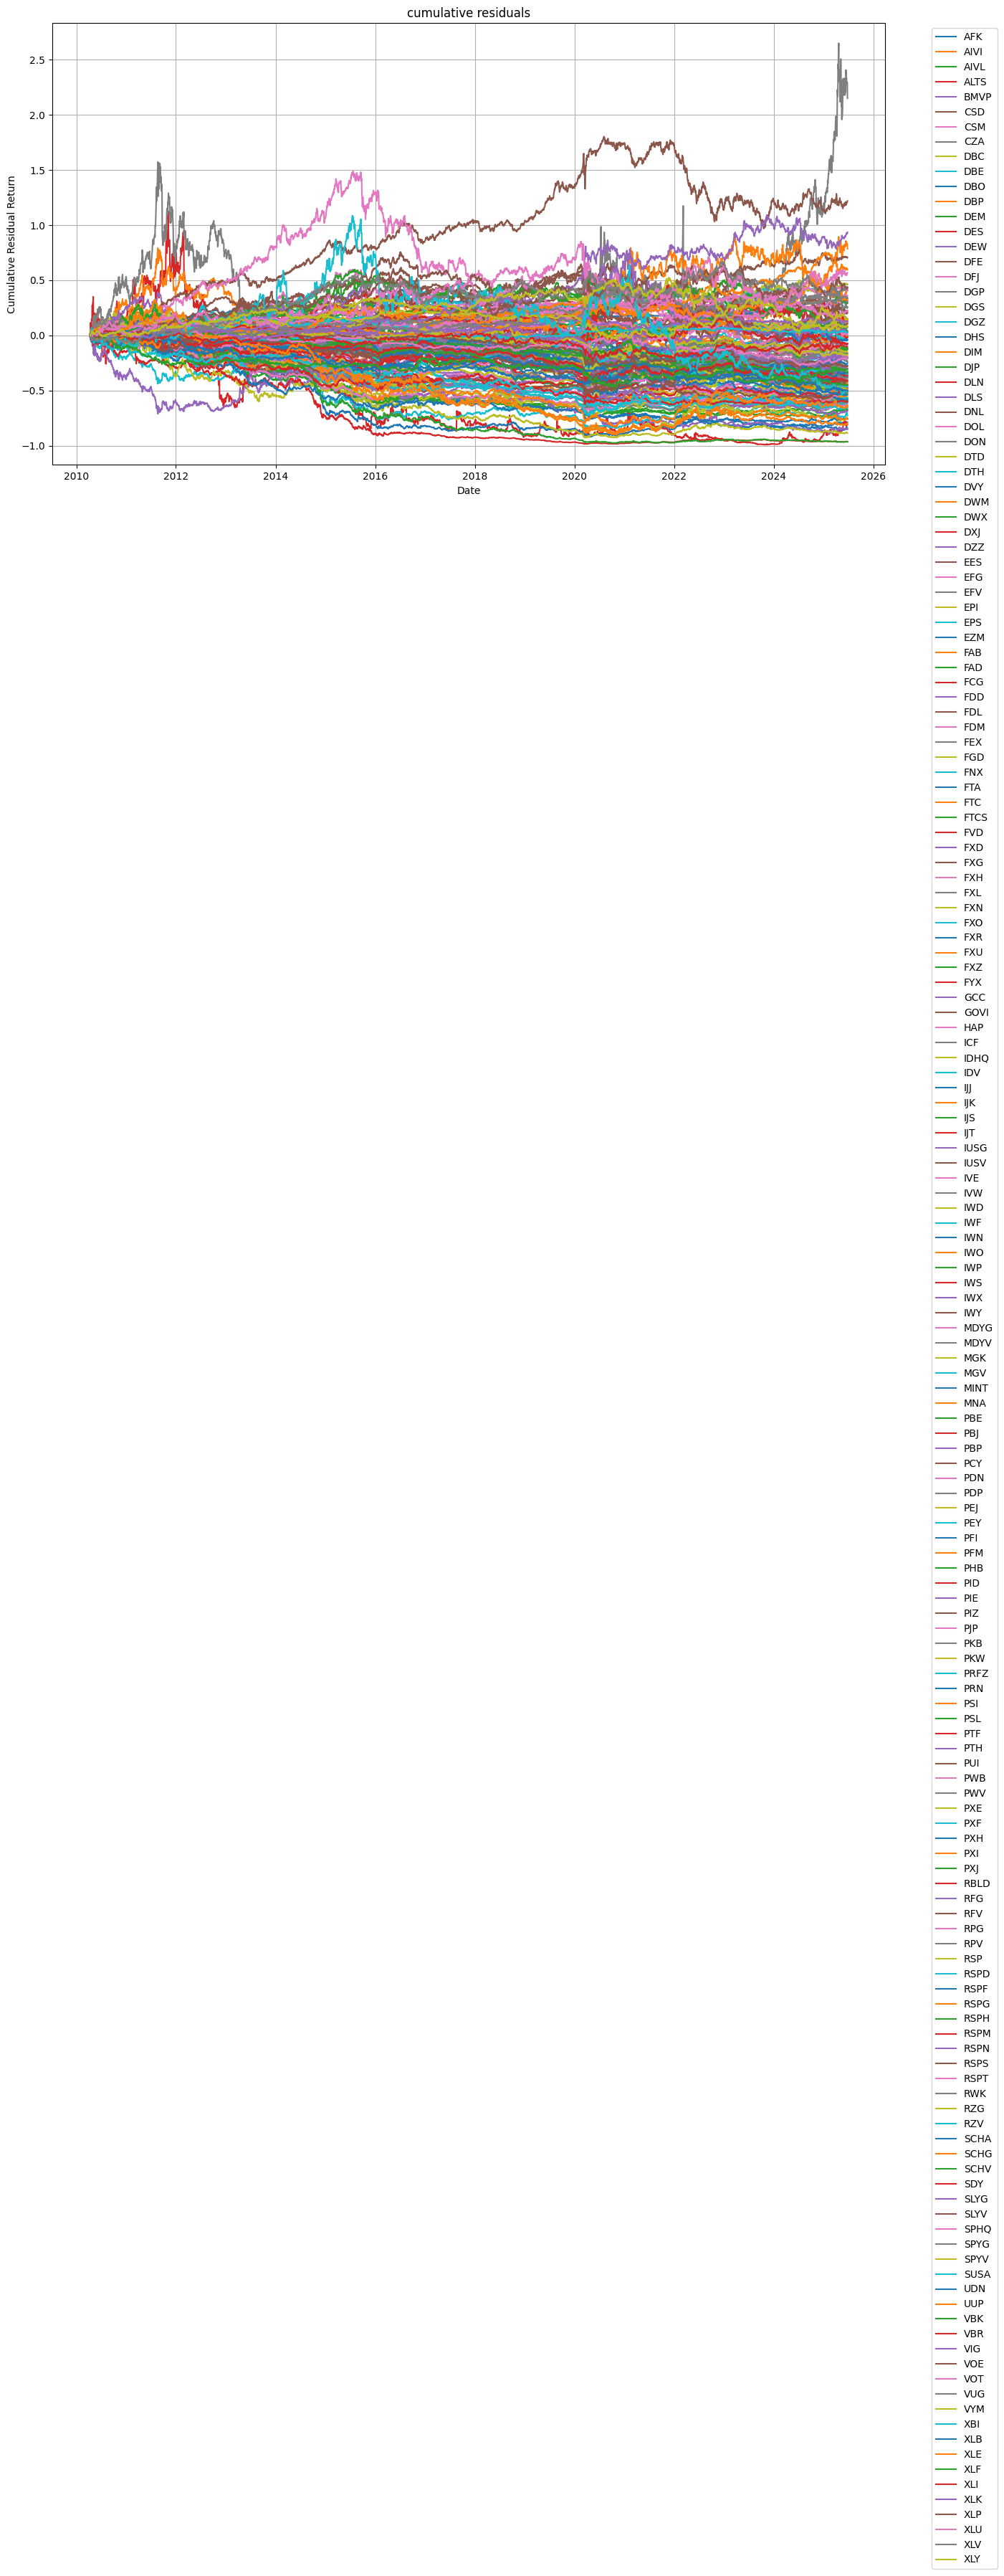

In [17]:
plot_cumulative_residuals(market_residuals, "cumulative residuals")

In [18]:
market_residuals

,AFK,AIVI,AIVL,ALTS,BMVP,CSD,CSM,CZA,DBC,DBE,...,XBI,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-12,0.007671,0.001828,-0.001208,-0.000751,-0.003501,0.005239,-0.000100,-0.002027,-0.003720,-0.006045,...,-0.005100,-0.007080,-0.001302,0.000703,-0.000855,-0.000670,0.001511,0.000318,-0.004976,-0.002673
2010-04-13,-0.014826,0.000912,-0.000457,0.034483,0.002721,0.000000,0.001283,0.005057,0.003713,0.001129,...,-0.000164,-0.003736,-0.003502,0.000602,0.001570,0.002975,-0.003200,-0.005277,0.000937,0.005299
2010-04-14,-0.007447,-0.004004,-0.006209,0.050194,-0.000471,-0.004152,0.000368,0.004302,-0.000589,-0.000743,...,-0.001762,-0.008913,-0.005677,0.011129,0.000080,0.002708,-0.005669,-0.008730,-0.012504,0.004352
2010-04-15,0.002081,-0.002545,0.002784,0.024999,0.003363,0.006262,0.001948,0.001820,0.002435,0.000413,...,-0.003920,-0.001658,-0.001703,-0.005595,0.008305,0.003413,-0.002498,-0.001314,-0.003736,0.003197
2010-04-16,0.001471,0.005506,0.002059,-0.023942,0.002487,-0.003767,-0.004218,0.010348,-0.003436,-0.000326,...,0.007533,0.002877,0.001682,-0.018499,-0.000641,0.000988,0.004390,0.000286,0.005110,0.000439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.005216,-0.007050,0.001195,-0.120456,0.001107,-0.000581,-0.001508,-0.002294,0.023831,0.039302,...,-0.005077,-0.001416,0.016478,0.002187,0.000947,0.005160,-0.004663,-0.004374,-0.011544,-0.005952
2025-06-18,0.007596,0.003215,0.000120,0.110057,-0.002460,0.004243,0.000237,0.000217,0.002542,0.003353,...,0.006597,-0.003049,-0.006700,-0.000573,-0.002572,0.000931,-0.001326,0.002528,-0.001833,0.000226
2025-06-20,-0.000754,-0.009563,0.004080,0.036053,0.003236,0.003151,0.000516,0.002668,0.005701,0.007972,...,-0.001369,-0.005123,0.011637,0.004363,0.002807,-0.001997,0.008097,0.003505,-0.003818,0.003431


In [19]:
def compute_mean_acf(df, lags=[1, 5, 21, 42 , 63]):
    acf_values = {lag: [] for lag in lags}

    for col in df.columns:
        series = df[col].dropna()
        acfs = sm.tsa.acf(series, nlags=max(lags), fft=True)
        for lag in lags:
            acf_values[lag].append(acfs[lag])

    mean_acfs = {lag: sum(acf_values[lag]) / len(acf_values[lag]) for lag in lags}
    return pd.Series(mean_acfs, name="Mean ACF")

In [20]:
compute_mean_acf(market_residuals.loc[:"2019-01-01"])

1    -0.069834
5     0.004543
21   -0.006298
42   -0.004361
63   -0.000424
Name: Mean ACF, dtype: float64

In [21]:
df_rets

,IWV,AFK,AIVI,AIVL,BMVP,CSD,CSM,CZA,DBC,DBE,...,XBI,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.002561,0.002067,-0.004908,-0.001446,0.001289,0.004199,0.004521,0.003370,0.001189,0.000000,...,0.003853,0.003234,0.008162,0.018380,0.003531,-0.001289,0.000375,-0.011905,-0.009807,0.003667
2010-01-06,0.001954,0.014781,0.000673,0.002173,0.001546,0.003660,0.001566,0.001679,0.017808,0.014590,...,0.013343,0.016994,0.011975,0.002005,0.002111,-0.011188,-0.000749,0.005861,0.010224,0.001328
2010-01-07,0.003449,-0.000677,-0.010307,0.000482,0.001286,0.003125,0.003908,0.000838,-0.012442,-0.004056,...,0.000000,-0.007779,-0.001500,0.021347,0.010885,-0.003916,0.000000,-0.004532,0.003479,0.008292
2010-01-08,0.003587,0.001695,0.012904,0.000963,0.001027,-0.001558,-0.000973,-0.000419,-0.000787,0.000370,...,0.004509,0.013937,0.006509,-0.005879,0.015978,0.006553,-0.003376,-0.000976,0.001576,-0.000329
2010-01-11,0.000893,0.008799,0.002459,0.006256,0.001796,0.007800,0.006234,0.005027,-0.003152,-0.010363,...,0.005387,-0.005441,-0.001326,0.000657,0.010941,-0.003906,0.002635,0.010417,0.005664,-0.001974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.009362,-0.011729,-0.012120,-0.005673,-0.005640,-0.011448,-0.010759,-0.009912,0.021239,0.036004,...,-0.015233,-0.009759,0.009335,-0.005739,-0.007519,-0.007077,-0.008495,-0.008269,-0.016506,-0.017241
2025-06-18,0.000207,0.007740,0.003327,0.000272,-0.002311,0.004483,0.000441,0.000385,0.002600,0.003426,...,0.006821,-0.002865,-0.006542,-0.000398,-0.002385,0.001202,-0.001242,0.002614,-0.001723,0.000475
2025-06-20,-0.001860,-0.002048,-0.010570,0.002716,0.001895,0.000992,-0.001322,0.001155,0.005186,0.007317,...,-0.003387,-0.006781,0.010218,0.002788,0.001125,-0.004429,0.007336,0.002731,-0.004803,0.001188


In [22]:
df_rets_original = df_rets.copy()
market_residuals_original = market_residuals.copy()

In [23]:
market_residuals.columns

Index(['AFK', 'AIVI', 'AIVL', 'ALTS', 'BMVP', 'CSD', 'CSM', 'CZA', 'DBC',
       'DBE',
       ...
       'XBI', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'],
      dtype='object', length=169)

In [24]:
df_rets = df_rets[cumul_etf]
market_residuals = market_residuals[cumul_etf]

In [25]:
market_returns

,IWV
Date,
2010-01-05,0.002561
2010-01-06,0.001954
2010-01-07,0.003449
2010-01-08,0.003587
2010-01-11,0.000893
...,...
2025-06-17,-0.009362
2025-06-18,0.000207
2025-06-20,-0.001860


In [26]:
market_residuals

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-12,0.000836,-0.001229,-0.000872,0.000410,-0.002238,0.000049,0.000743,-0.000804,-0.001189,0.002569,...,0.001115,-0.001355,-0.000666,-0.001817,-0.002278,-0.004633,-0.001693,-0.000909,-0.000730,-0.001512
2010-04-13,-0.003991,0.000597,0.004468,0.000476,0.000954,0.003741,-0.000362,0.000363,-0.000694,-0.001531,...,0.002691,0.003747,0.003686,0.003619,0.001512,0.004959,0.001891,0.001151,0.001598,0.001182
2010-04-14,0.003508,-0.001134,0.004917,0.000877,-0.000030,0.006498,0.006604,0.001528,-0.004516,-0.002934,...,0.007879,0.003839,0.003670,-0.001341,0.005651,0.003163,-0.002532,-0.006172,-0.003169,-0.003466
2010-04-15,-0.005996,-0.003129,0.000023,-0.002555,-0.004977,0.001923,0.000312,-0.000953,-0.002035,-0.000191,...,0.001905,0.000043,-0.000651,-0.000939,0.002079,0.004409,0.002068,0.000080,-0.001985,-0.000135
2010-04-16,-0.006488,-0.000867,0.002374,-0.003946,0.001006,0.001950,-0.011497,-0.004035,0.001916,-0.002654,...,0.006357,0.003962,0.005423,0.005643,0.000117,0.006370,0.000972,0.001446,0.001515,0.001369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,0.001083,-0.000743,-0.000554,-0.000769,-0.001394,-0.000618,-0.000489,-0.001507,-0.003952,-0.006877,...,0.002049,0.001336,-0.001626,0.003036,0.001653,0.000038,0.002164,-0.000516,0.000548,0.000206
2025-06-18,0.000596,0.001136,0.003967,0.001742,0.003481,0.005232,0.000832,0.000814,0.002479,0.003258,...,0.002736,0.003005,0.001813,0.002285,-0.003568,-0.008767,-0.001596,0.000227,0.000236,0.001881
2025-06-20,0.005566,0.003269,0.003470,0.003019,0.003382,-0.000249,0.003007,0.003651,-0.006288,-0.006365,...,0.001335,0.003328,0.003928,0.003767,0.003435,0.000633,-0.004758,0.002323,0.002000,0.003639


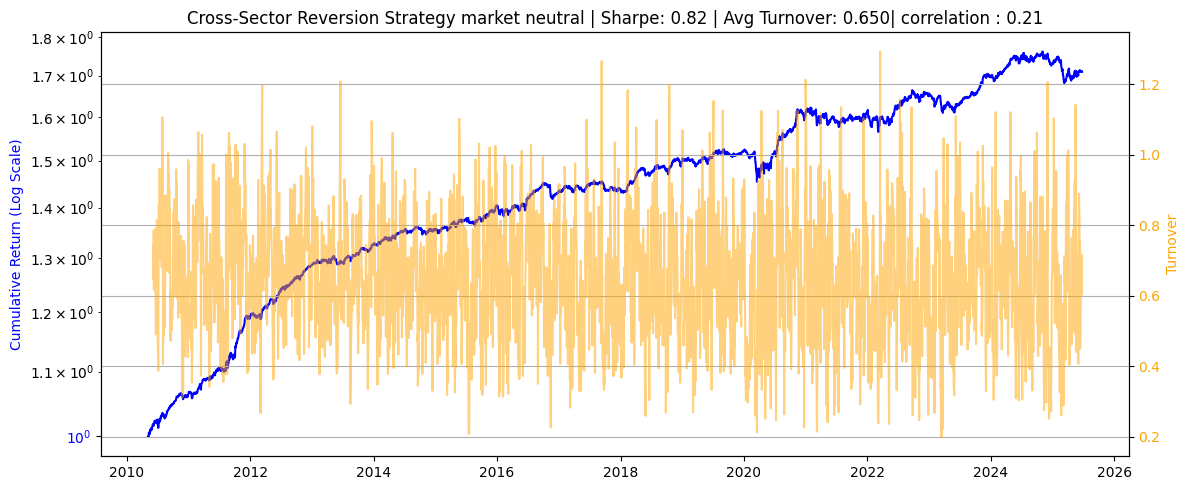

In [27]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

def backtest(df_rets, market_residuals, market_returns, etf_assortment, rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True,
              exponential_weights = True, sector_neutral = True, percentile = True, market_hedged = False, beta_window = 60, weights_clip = False, max_weight = 0.05
              , beta_hedge = False, lag = 1, rolling_window = True, rolling_window_size = 3, corr= True, market_1 = True):
    
    sector_resid = market_residuals
    if vol_scale:
        vol = sector_resid.rolling(vol_window).std().dropna()
        scaled_sector_resid = sector_resid / (vol + 1e-6)
        cumulative_resid = (1+scaled_sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
        daily_reverse_signal = - cumulative_resid
    else:
        cumulative_resid = (1+sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
        daily_reverse_signal = - cumulative_resid
    
    z_scores_group = daily_reverse_signal.sub(cumulative_resid.mean(axis=1), axis = 0).div(cumulative_resid.std(axis=1), axis = 0)
    if sector_neutral:
        for etfs in etf_assortment:
            z = z_scores_group[etfs]
            z_sector_adj = z.sub(z.mean(axis=1), axis=0)
            z_scores_group[etfs] = z_sector_adj
        z_all = z_scores_group
    else:
        z_all = z_scores_group
    if not percentile:
        z_scores = (z_all.sub(z_all.mean(axis=1), axis  = 0).div(z_all.std(axis=1), axis = 0))
        long_signals = z_scores.clip(lower=0)
        short_signals = z_scores.clip(upper=0)
        
        long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2
        weights = long_weights + short_weights
        if exponential_weights:
            weights = weights.ewm(span=10, adjust=False).mean()

            long_weights = weights.clip(lower=0)
            short_weights = weights.clip(upper=0)

            long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
            short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

            weights = long_weights + short_weights
    else:
        z_scores = (z_all.sub(z_all.mean(axis=1), axis=0)
                  .div(z_all.std(axis=1), axis=0))

        quantile = 0.1
        top_mask = z_scores.ge(z_scores.quantile(1 - quantile, axis=1), axis=0)
        bottom_mask = z_scores.le(z_scores.quantile(quantile, axis=1), axis=0)

        long_signals = z_scores.where(top_mask, 0)
        short_signals = z_scores.where(bottom_mask, 0)
        long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2

        weights = long_weights + short_weights

    if weights_clip:
        max_change = max_weight 

        weights_clipped = weights.copy()
        for t in range(1, len(weights)):
            delta = weights.iloc[t] - weights_clipped.iloc[t - 1]
            delta = delta.clip(lower=-max_change, upper=max_change)
            weights_clipped.iloc[t] = weights_clipped.iloc[t - 1] + delta
        weights = weights_clipped
        long_weights = weights.clip(lower=0)
        short_weights = weights.clip(upper=0)

        long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

        weights = long_weights + short_weights
    df_rets.index = pd.to_datetime(df_rets.index)
    weights.index = pd.to_datetime(weights.index)
    if vol_scale:
        common_dates = weights.index.intersection(df_rets.index).intersection(vol.index)
    else:
        common_dates = weights.index.intersection(df_rets.index)
    weights = weights.loc[common_dates]
    df_rets = df_rets.loc[common_dates]
    
    turnover = pd.Series(index=weights.index, dtype=float)

    if rolling_window:
        weights = weights.rolling(window = rolling_window_size).mean()
        

    # avg_turnover = compute_turnover_accurate(weights, df_rets)

    turnover = pd.Series(index=weights.index, dtype=float)

    for t in range(vol_window, len(weights)):
        prev = weights.iloc[t - 1]
        curr = weights.iloc[t]
        turnover.iloc[t] = (curr - prev).abs().sum()

    avg_turnover = turnover.dropna().mean()
    strategy_returns = (weights.shift(lag) * df_rets).sum(axis=1)
    if beta_hedge: 
        aligned_returns = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned_returns.columns = ['strategy', 'market']
        # Set rolling window
        window = 60  # 60 day
        # Add constant for intercept in regression
        X = sm.add_constant(aligned_returns['market'])
        y = aligned_returns['strategy']
        rolling_ols = RollingOLS(endog=y, exog=X, window=window)
        rolling_res = rolling_ols.fit()
        rolling_beta = rolling_res.params['market']
        # Align beta with strategy_returns and calculate residuals
        beta_aligned = rolling_beta.shift(1)  # Avoid look-ahead bias
        strategy_neutralized = aligned_returns['strategy'] - beta_aligned * aligned_returns['market']
        strategy_neutralized.name = 'strategy_beta_neutral'
        strategy_returns = strategy_neutralized
    if not market_hedged:
        same_date = strategy_returns.index.intersection(rf_daily.index)
        sharpe = ((strategy_returns[same_date] - rf_daily[same_date]).mean()) / strategy_returns.std() * np.sqrt(252)
    else:
        window = beta_window
        aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned.columns = ['strategy', 'market']
        rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
        if not market_1:
            hedged_returns = aligned['strategy'] - rolling_beta * aligned['market']

        else:
            hedged_returns = aligned['strategy'] + (1- rolling_beta ) * aligned['market']
        strategy_returns = hedged_returns
        same_date = strategy_returns.index.intersection(rf_daily.index)
        sharpe = ((strategy_returns[same_date] - rf_daily[same_date]).mean()) / strategy_returns.std() * np.sqrt(252)
    if corr:
        window = 60
        aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned.columns = ['strategy', 'market']
        rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
        aligned = aligned.iloc[1:]
        corr = aligned.corr().iloc[0,1]
        
    # if plot_true:
    #     cum_returns = (1 + strategy_returns).cumprod()
    #     fig, ax1 = plt.subplots(figsize=(12, 5))

    #     ax1.plot(cum_returns, color='blue', label='Cumulative Return')
    #     ax1.set_ylabel('Cumulative Return', color='blue')
    #     ax1.tick_params(axis='y', labelcolor='blue')

    #     ax2 = ax1.twinx()
    #     ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
    #     ax2.set_ylabel('Turnover', color='orange')
    #     ax2.tick_params(axis='y', labelcolor='orange')

    #     plt.title(f'Cross-Sector Reversion Strategy | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}')
    #     fig.tight_layout()
    #     plt.grid(True)
    #     plt.show()
        
    if plot_true:
        cum_returns = (1 + strategy_returns).cumprod()
        fig, ax1 = plt.subplots(figsize=(12, 5))

        ax1.plot(cum_returns, color='blue', label='Cumulative Return')
        ax1.set_ylabel('Cumulative Return (Log Scale)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_yscale("log")

        ax2 = ax1.twinx()
        ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
        ax2.set_ylabel('Turnover', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        plt.title(f'Cross-Sector Reversion Strategy market neutral | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}'
                  f'| correlation : {corr:.2f}')
        fig.tight_layout()
        plt.grid(True)
        plt.show()

        return (long_weights,short_weights,weights,strategy_returns)
    
(long_weights,short_weights,weights,strategy_returns) = backtest(df_rets, market_residuals,market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = True, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 40, beta_hedge=False, rolling_window = False, rolling_window_size=4)


In [28]:
weights.to_csv("weights.csv")

In [29]:
df_rets

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.009091,0.003110,-0.001081,0.005980,0.008258,-0.003693,0.014363,0.005222,0.003608,0.006376,...,0.001544,0.003428,0.004904,0.006750,0.004869,0.006167,0.000198,-0.000718,-0.001195,0.001708
2010-01-06,0.009009,0.007086,0.001623,0.003398,0.003699,-0.002022,0.000000,0.003247,-0.003146,0.002880,...,-0.002055,0.003796,0.007321,0.007040,0.013500,-0.001752,0.000000,0.000479,0.000000,0.004264
2010-01-07,0.015828,0.007256,0.008821,0.008464,0.007106,0.011818,0.016074,0.007380,-0.009465,-0.004020,...,0.004633,0.004917,0.004844,0.000998,0.007172,0.000877,0.000792,0.001676,0.003589,0.002123
2010-01-08,-0.000399,0.003274,0.003569,0.002350,0.004705,0.005507,-0.004896,0.002699,0.008646,0.010571,...,0.001879,0.003011,0.006830,0.007150,0.007121,0.001753,0.005539,0.001911,0.001193,0.004661
2010-01-11,0.003996,0.000870,-0.000534,0.002345,0.000780,-0.005643,0.007570,0.002435,0.008346,0.005516,...,-0.001534,0.002251,-0.001596,-0.004128,0.000674,-0.000875,-0.001771,0.004292,0.003810,0.001687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.006240,-0.008168,-0.009559,-0.008248,-0.009810,-0.009857,-0.007030,-0.008945,-0.009214,-0.012910,...,-0.007787,-0.008242,-0.011228,-0.007495,-0.008456,-0.008230,-0.008850,-0.007185,-0.006277,-0.008200
2025-06-18,0.000758,0.001300,0.004166,0.001907,0.003666,0.005436,0.000977,0.000979,0.002595,0.003391,...,0.002953,0.003217,0.002025,0.002517,-0.003345,-0.008585,-0.001353,0.000374,0.000387,0.002067
2025-06-20,0.004111,0.001793,0.001681,0.001533,0.001710,-0.002085,0.001707,0.002173,-0.007334,-0.007564,...,-0.000620,0.001425,0.002021,0.001674,0.001426,-0.001010,-0.006946,0.000998,0.000644,0.001969


In [30]:
weights.to_csv("weights from 2011-1-1 to 2023-12-29.csv")

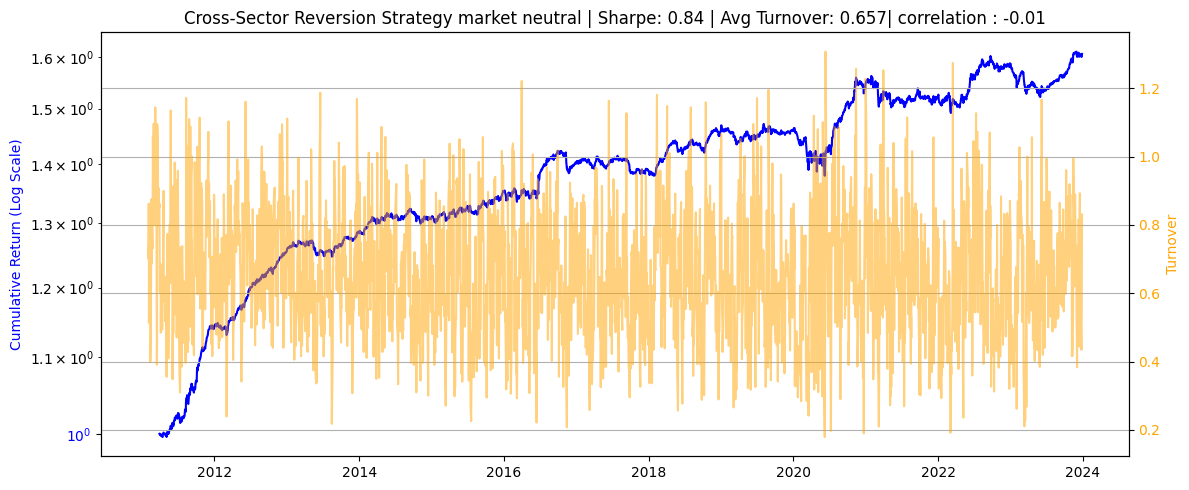

In [31]:
(long_weights,short_weights,weights,strategy_returns) = backtest(df_rets.loc['2010-12-31':'2023-12-31'], market_residuals.loc['2010-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 40, beta_hedge=True, rolling_window = False, rolling_window_size=4)

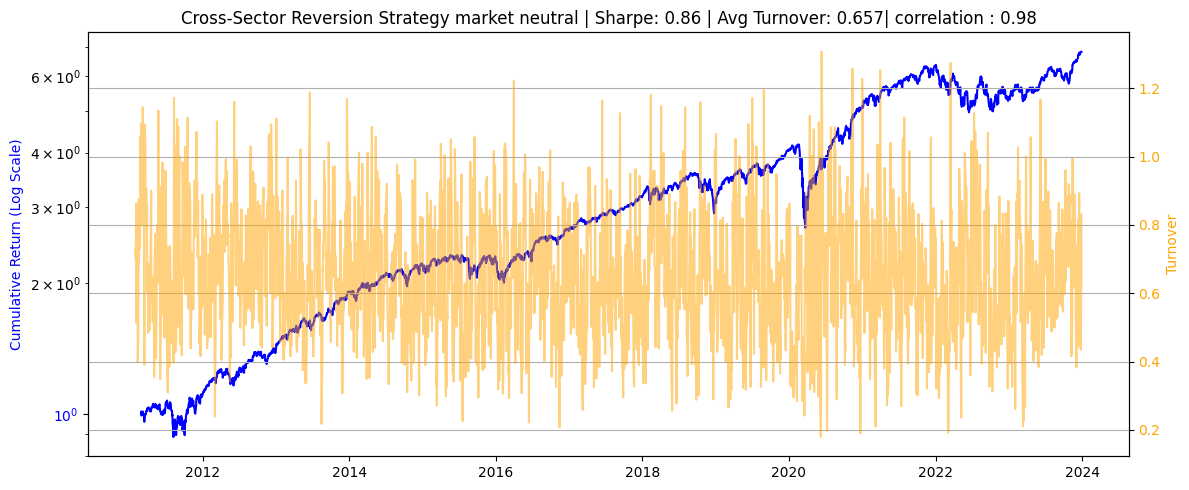

In [32]:
(long_weights,short_weights,weights,strategy_returns) = backtest(df_rets.loc['2010-12-31':'2023-12-31'], market_residuals.loc['2010-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = True,
          beta_window= 40, beta_hedge=False, rolling_window = False, rolling_window_size=4)

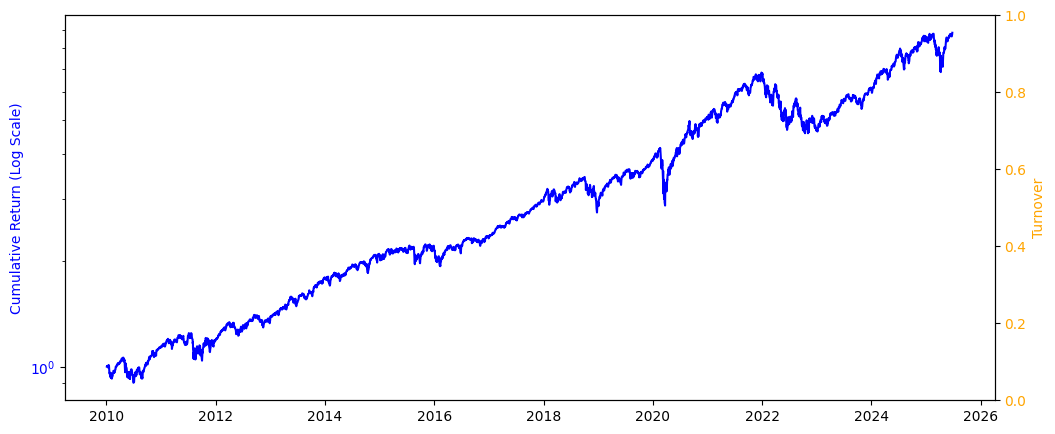

In [33]:
cum_returns = (1 + df_rets['IVW']).cumprod()
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(cum_returns, color='blue', label='Cumulative Return')
ax1.set_ylabel('Cumulative Return (Log Scale)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale("log")

ax2 = ax1.twinx()
ax2.set_ylabel('Turnover', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

In [34]:
strategy_returns

Date
2010-12-31         NaN
2011-01-03         NaN
2011-01-04         NaN
2011-01-05         NaN
2011-01-06         NaN
                ...   
2023-12-22    0.001521
2023-12-26    0.003003
2023-12-27    0.001819
2023-12-28    0.001241
2023-12-29   -0.001515
Length: 3271, dtype: float64

In [35]:
market_returns['IWV']

Date
2010-01-05    0.002561
2010-01-06    0.001954
2010-01-07    0.003449
2010-01-08    0.003587
2010-01-11    0.000893
                ...   
2025-06-17   -0.009362
2025-06-18    0.000207
2025-06-20   -0.001860
2025-06-23    0.009821
2025-06-24    0.008729
Name: IWV, Length: 3891, dtype: float64

In [36]:
market_residuals

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-12,0.000836,-0.001229,-0.000872,0.000410,-0.002238,0.000049,0.000743,-0.000804,-0.001189,0.002569,...,0.001115,-0.001355,-0.000666,-0.001817,-0.002278,-0.004633,-0.001693,-0.000909,-0.000730,-0.001512
2010-04-13,-0.003991,0.000597,0.004468,0.000476,0.000954,0.003741,-0.000362,0.000363,-0.000694,-0.001531,...,0.002691,0.003747,0.003686,0.003619,0.001512,0.004959,0.001891,0.001151,0.001598,0.001182
2010-04-14,0.003508,-0.001134,0.004917,0.000877,-0.000030,0.006498,0.006604,0.001528,-0.004516,-0.002934,...,0.007879,0.003839,0.003670,-0.001341,0.005651,0.003163,-0.002532,-0.006172,-0.003169,-0.003466
2010-04-15,-0.005996,-0.003129,0.000023,-0.002555,-0.004977,0.001923,0.000312,-0.000953,-0.002035,-0.000191,...,0.001905,0.000043,-0.000651,-0.000939,0.002079,0.004409,0.002068,0.000080,-0.001985,-0.000135
2010-04-16,-0.006488,-0.000867,0.002374,-0.003946,0.001006,0.001950,-0.011497,-0.004035,0.001916,-0.002654,...,0.006357,0.003962,0.005423,0.005643,0.000117,0.006370,0.000972,0.001446,0.001515,0.001369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,0.001083,-0.000743,-0.000554,-0.000769,-0.001394,-0.000618,-0.000489,-0.001507,-0.003952,-0.006877,...,0.002049,0.001336,-0.001626,0.003036,0.001653,0.000038,0.002164,-0.000516,0.000548,0.000206
2025-06-18,0.000596,0.001136,0.003967,0.001742,0.003481,0.005232,0.000832,0.000814,0.002479,0.003258,...,0.002736,0.003005,0.001813,0.002285,-0.003568,-0.008767,-0.001596,0.000227,0.000236,0.001881
2025-06-20,0.005566,0.003269,0.003470,0.003019,0.003382,-0.000249,0.003007,0.003651,-0.006288,-0.006365,...,0.001335,0.003328,0.003928,0.003767,0.003435,0.000633,-0.004758,0.002323,0.002000,0.003639


In [37]:
window = 60
aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
aligned.columns = ['strategy', 'market']
rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
aligned = aligned.iloc[1:]
aligned.corr()

,strategy,market
strategy,1.000000,0.983876
market,0.983876,1.000000


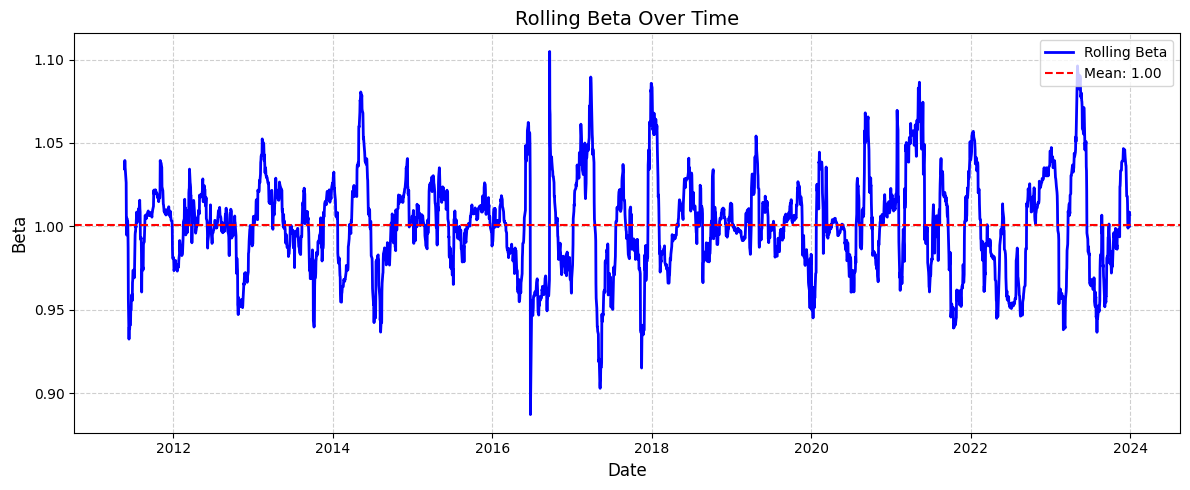

In [38]:
mean_beta = rolling_beta.mean()
plt.figure(figsize=(12, 5))
plt.plot(rolling_beta, label='Rolling Beta', color='blue', linewidth=2)
plt.axhline(mean_beta, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_beta:.2f}')

plt.title('Rolling Beta Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Beta', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

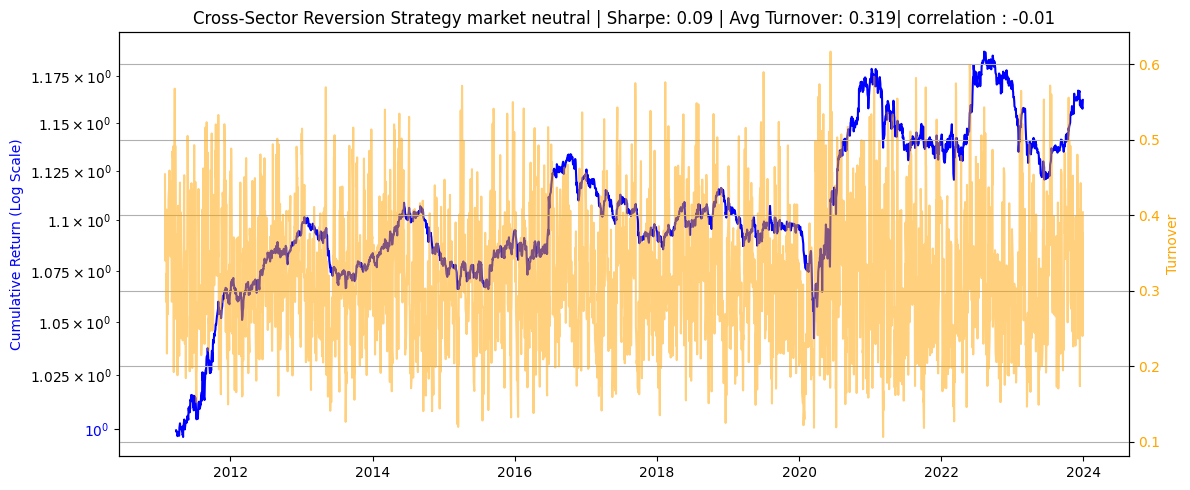

In [39]:
(long_weights,short_weights,weights,strategy_returns) = backtest(df_rets.loc['2010-12-31':'2023-12-31'], market_residuals.loc['2010-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 60, beta_hedge=True)

In [40]:
window = 60
aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
aligned.columns = ['strategy', 'market']
rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
aligned = aligned.iloc[1:]
aligned.corr()

,strategy,market
strategy,1.000000,-0.006982
market,-0.006982,1.000000


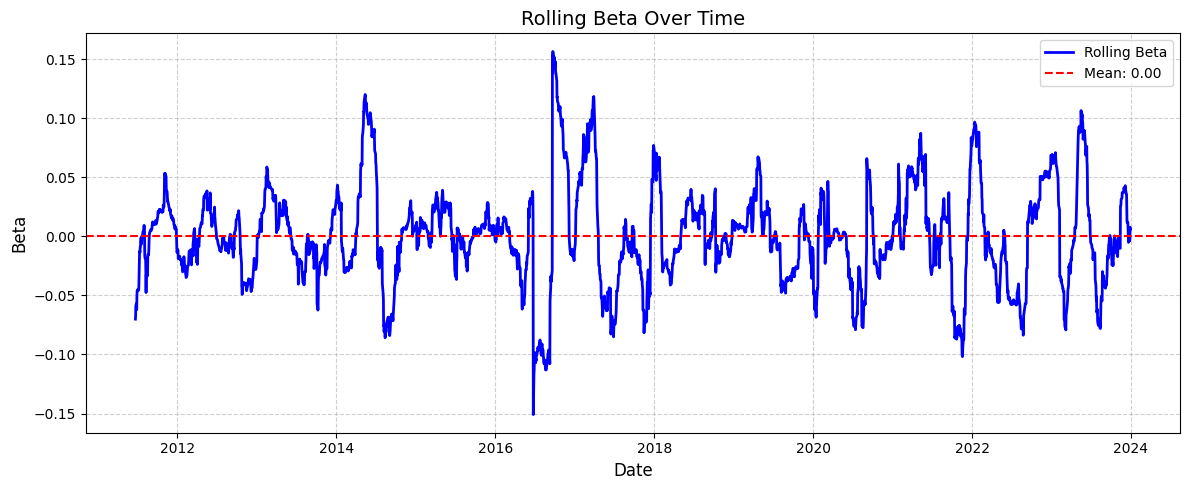

In [41]:
mean_beta = rolling_beta.mean()
plt.figure(figsize=(12, 5))
plt.plot(rolling_beta, label='Rolling Beta', color='blue', linewidth=2)
plt.axhline(mean_beta, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_beta:.2f}')

plt.title('Rolling Beta Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Beta', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

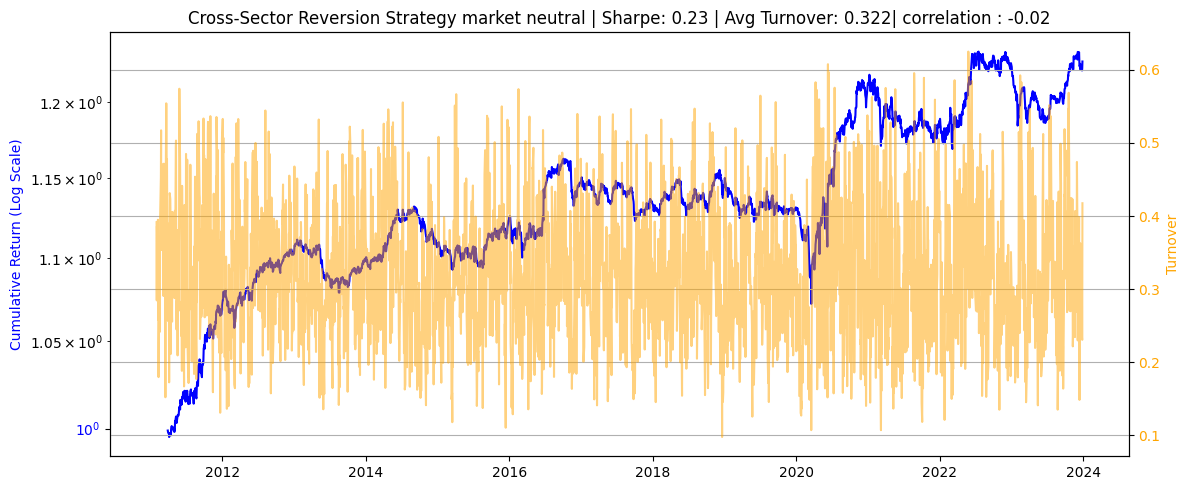

In [42]:
(long_weights,short_weights,weights,strategy_returns) = backtest(df_rets.loc['2010-12-31':'2023-12-31'], df_rets.loc['2010-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 60,beta_hedge=True)

In [43]:
window = 60
aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
aligned.columns = ['strategy', 'market']
rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
aligned = aligned.iloc[1:]
aligned.corr()

,strategy,market
strategy,1.000000,-0.020903
market,-0.020903,1.000000


In [44]:
weights.clip(lower=0).sum(axis = 1)

Date
2010-12-31    0.000000
2011-01-03    0.000000
2011-01-04    0.495482
2011-01-05    0.495889
2011-01-06    0.483978
                ...   
2023-12-22    0.441629
2023-12-26    0.473064
2023-12-27    0.480766
2023-12-28    0.465118
2023-12-29    0.442098
Length: 3271, dtype: float64

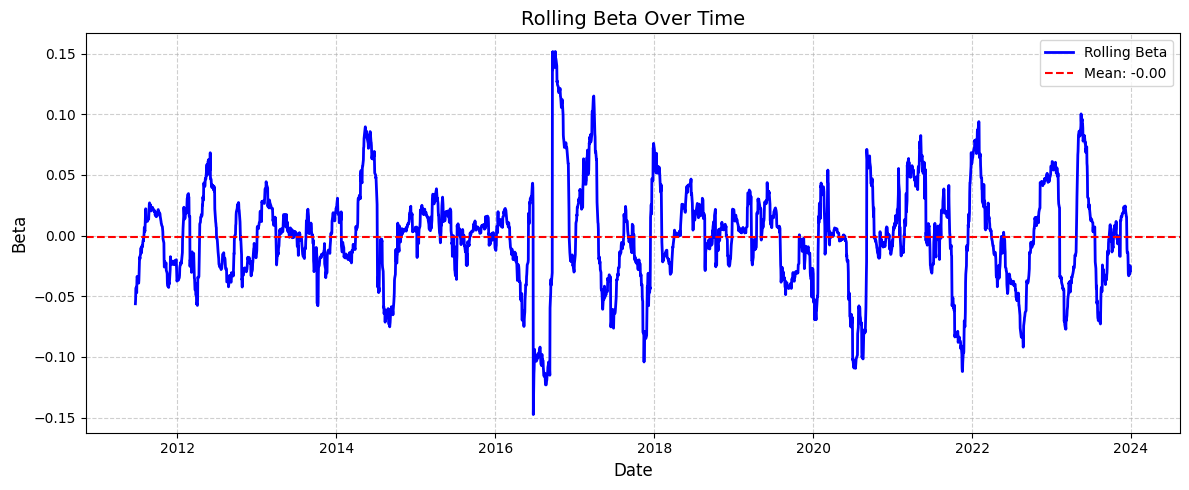

In [45]:
mean_beta = rolling_beta.mean()
plt.figure(figsize=(12, 5))
plt.plot(rolling_beta, label='Rolling Beta', color='blue', linewidth=2)
plt.axhline(mean_beta, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_beta:.2f}')

plt.title('Rolling Beta Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Beta', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

In [46]:
#def backtest2(df_rets, market_residuals, etf_assortment, rf_daily, long_window = 40, short_window = 5,vol_window = 100, vol_scale = False, plot_true = True,
    #           exponential_weights = True, sector_neutral = True, percentile = True):
    
    
    # sector_resid = market_residuals
    # if vol_scale:
    #     vol = sector_resid.rolling(vol_window).std().dropna()
    #     scaled_sector_resid = sector_resid / (vol + 1e-6)
    #     cumulative_resid = (1+scaled_sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
    #     daily_reverse_signal = - cumulative_resid
    # else:
    #     long_signals = (1+sector_resid).rolling(window=long_window).apply(np.prod, raw=True) - 1 
    #     cumulative_resid = long_signals
    #     daily_reverse_signal = cumulative_resid
    # # time sereis_operation is possible

    # #
    # z_scores_group = daily_reverse_signal.sub(cumulative_resid.mean(axis=1), axis = 0).div(cumulative_resid.std(axis=1), axis = 0)
    # # print(z_scores_group)
    # if sector_neutral:
    #     for etfs in etf_assortment:
    #         z = z_scores_group[etfs]
    #         z_sector_adj = z.sub(z.mean(axis=1), axis=0)
    #         z_scores_group[etfs] = z_sector_adj
    #     z_all = z_scores_group
    # else:
    #     z_all = z_scores_group
    # if not percentile:
    #     z_scores = (z_all.sub(z_all.mean(axis=1), axis  = 0).div(z_all.std(axis=1), axis = 0))
    #     long_signals = z_scores.clip(lower=0)
    #     short_signals = z_scores.clip(upper=0)
        
    #     long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
    #     short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2
    #     weights = long_weights + short_weights
    #     if exponential_weights:
    #         weights = weights.ewm(span=10, adjust=False).mean()

    #         long_weights = weights.clip(lower=0)
    #         short_weights = weights.clip(upper=0)

    #         long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
    #         short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

    #         weights = long_weights + short_weights
    # else:
    #     z_scores = (z_all.sub(z_all.mean(axis=1), axis=0)
    #               .div(z_all.std(axis=1), axis=0))

    #     quantile = 0.1
    #     top_mask = z_scores.ge(z_scores.quantile(1 - quantile, axis=1), axis=0)
    #     bottom_mask = z_scores.le(z_scores.quantile(quantile, axis=1), axis=0)

    #     long_signals = z_scores.where(top_mask, 0)
    #     short_signals = z_scores.where(bottom_mask, 0)
    #     long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
    #     short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2

    #     weights = long_weights + short_weights



    # df_rets.index = pd.to_datetime(df_rets.index)
    # weights.index = pd.to_datetime(weights.index)
    # if vol_scale:
    #     common_dates = weights.index.intersection(df_rets.index).intersection(vol.index)
    # else:
    #     common_dates = weights.index.intersection(df_rets.index)
    # weights = weights.loc[common_dates]
    # df_rets = df_rets.loc[common_dates]
    
    # turnover = pd.Series(index=weights.index, dtype=float)

    # for t in range(vol_window, len(weights)):
    #     prev = weights.iloc[t - 1]
    #     curr = weights.iloc[t]
    #     turnover.iloc[t] = (curr - prev).abs().sum()

    # avg_turnover = turnover.dropna().mean()
    # strategy_returns = (weights.shift(1) * df_rets).sum(axis=1)
    # same_date = strategy_returns.index.intersection(rf_daily.index)
    # sharpe = ((strategy_returns[same_date] - rf_daily[same_date]).mean()) / strategy_returns.std() * np.sqrt(252)

    # if plot_true:
    #     cum_returns = (1 + strategy_returns).cumprod()
    #     fig, ax1 = plt.subplots(figsize=(12, 5))

    #     ax1.plot(cum_returns, color='blue', label='Cumulative Return')
    #     ax1.set_ylabel('Cumulative Return', color='blue')
    #     ax1.tick_params(axis='y', labelcolor='blue')

    #     ax2 = ax1.twinx()
    #     ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
    #     ax2.set_ylabel('Turnover', color='orange')
    #     ax2.tick_params(axis='y', labelcolor='orange')

    #     plt.title(f'Cross-Sector Reversion Strategy | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}')
    #     fig.tight_layout()
    #     plt.grid(True)
    #     plt.show()

    #     return weights 

In [47]:
russel = pd.read_csv("russel 2000.csv")
russel = russel[1:]
russel.columns = ['Date'] + list(russel.columns[1:])
russel['Date'] = pd.to_datetime(russel['Date'])
russel.set_index("Date",inplace=True)
russel = russel.apply(pd.to_numeric, errors='coerce')
non_numeric_mask = ~russel.applymap(lambda x: isinstance(x, (int, float)))
non_numeric_cols = non_numeric_mask.any()
print(non_numeric_cols[non_numeric_cols].index.tolist())
non_numeric_mask = ~russel.applymap(lambda x: isinstance(x, (int, float, np.integer, np.floating)))
non_numeric_positions = non_numeric_mask[non_numeric_mask]
for row_idx, col in non_numeric_positions.stack().index:
    val = russel.loc[row_idx, col]

/var/folders/6x/xp45m8ws0zj3yl7vwtwgbs8c0000gn/T/ipykernel_43636/3456777712.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251

[]


/var/folders/6x/xp45m8ws0zj3yl7vwtwgbs8c0000gn/T/ipykernel_43636/3456777712.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_mask = ~russel.applymap(lambda x: isinstance(x, (int, float, np.integer, np.floating)))


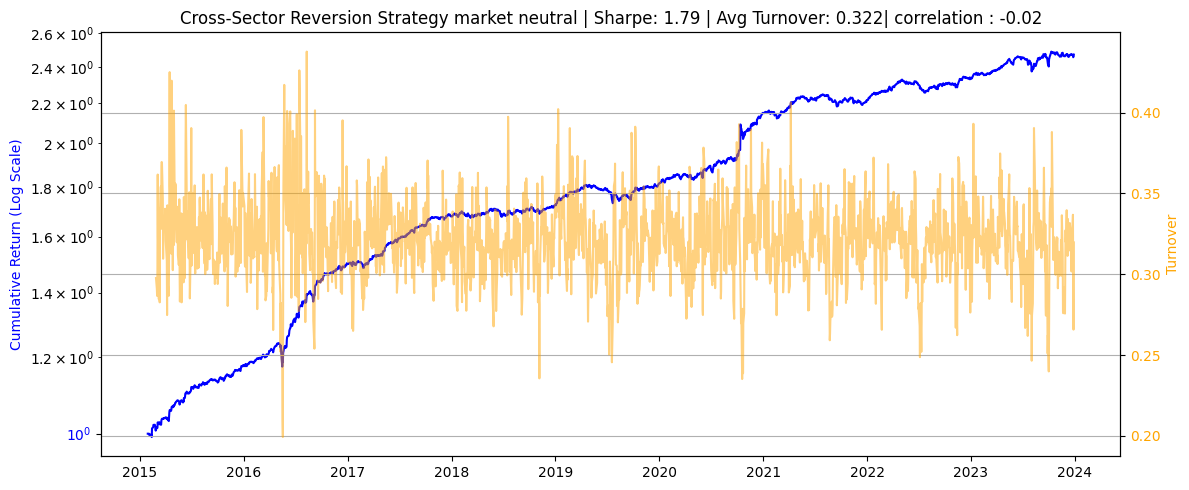

In [48]:
(long_weights,short_weights,weights,strategy_returns) = backtest(russel.loc['2014-12-31':'2023-12-31'], russel.loc['2014-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = True, plot_true = True, sector_neutral= False, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 60, beta_hedge = False)

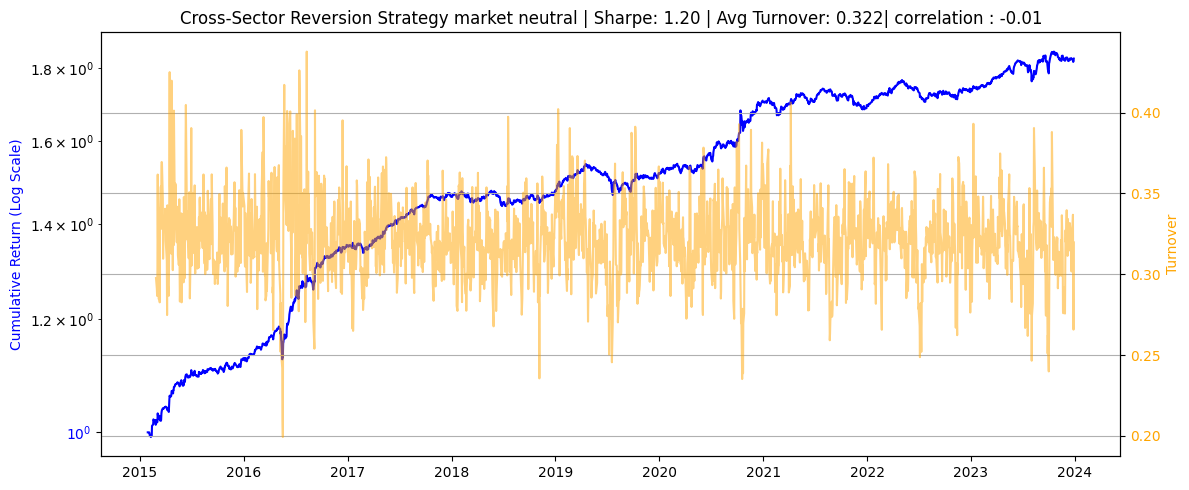

In [49]:
(long_weights,short_weights,weights,strategy_returns) = backtest(russel.loc['2014-12-31':'2023-12-31'], russel.loc['2014-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = True, plot_true = True, sector_neutral= False, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 60, beta_hedge = False, lag = 2)

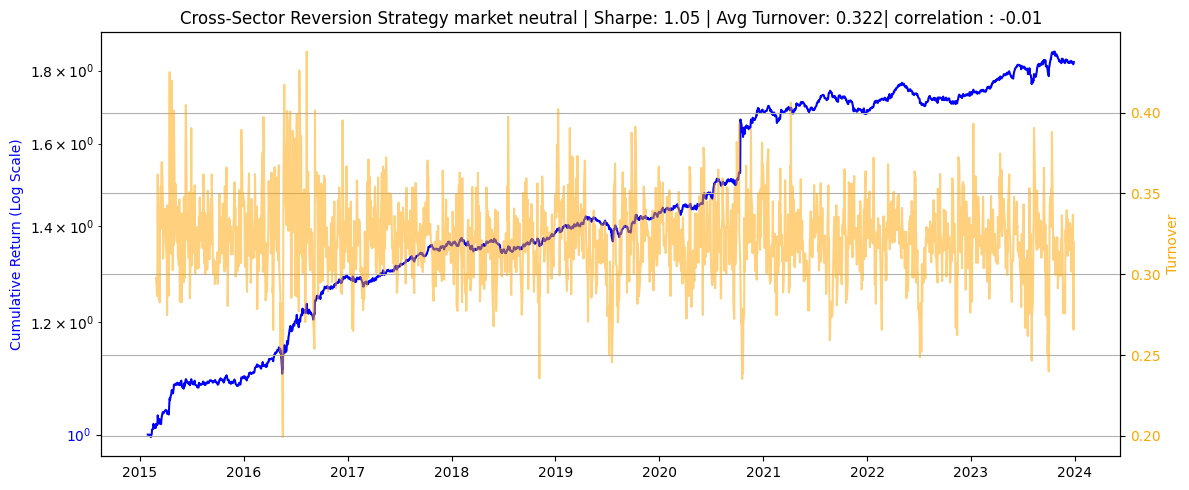

In [50]:
(long_weights,short_weights,weights,strategy_returns) = backtest(russel.loc['2014-12-31':'2023-12-31'], russel.loc['2014-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = True, plot_true = True, sector_neutral= False, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 60, beta_hedge = False, lag = 3)

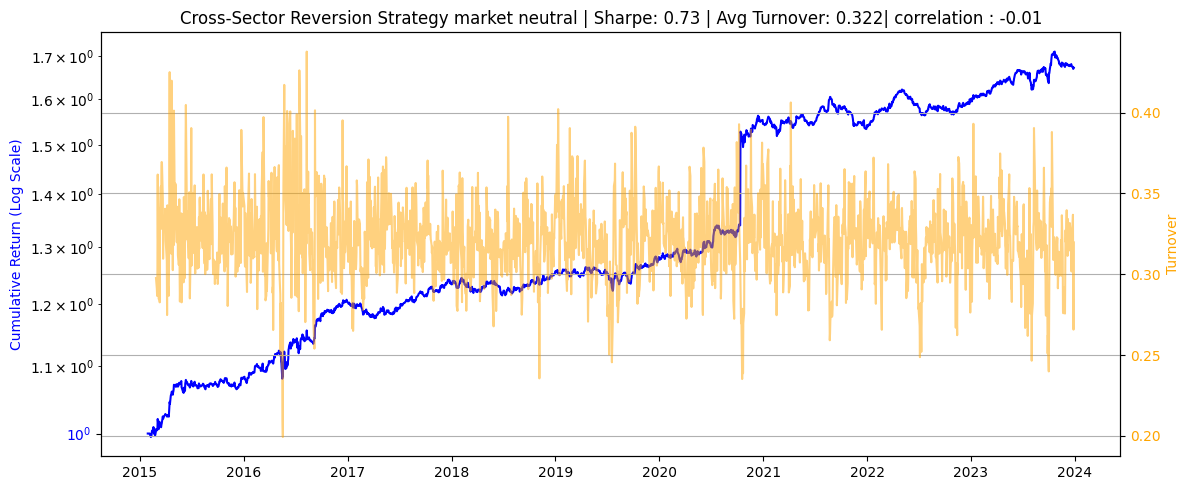

In [51]:
(long_weights,short_weights,weights,strategy_returns) = backtest(russel.loc['2014-12-31':'2023-12-31'], russel.loc['2014-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = True, plot_true = True, sector_neutral= False, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 60, beta_hedge = False, lag = 4)

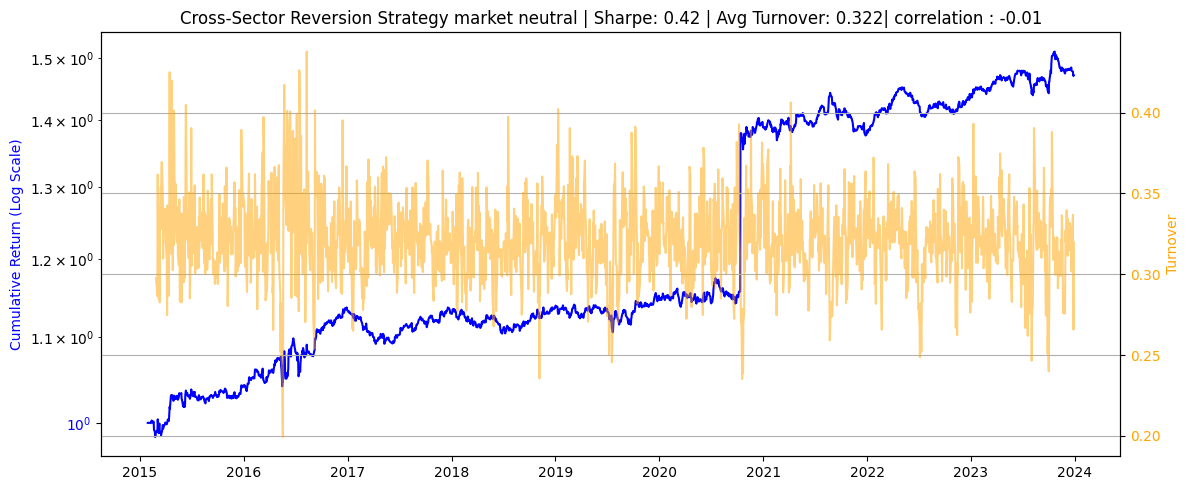

In [52]:
(long_weights,short_weights,weights,strategy_returns) = backtest(russel.loc['2014-12-31':'2023-12-31'], russel.loc['2014-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = True, plot_true = True, sector_neutral= False, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 60, beta_hedge = False, lag = 5)

In [53]:
window = 60
aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
aligned.columns = ['strategy', 'market']
rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
aligned = aligned.iloc[1:]
aligned.corr()

,strategy,market
strategy,1.000000,-0.012732
market,-0.012732,1.000000


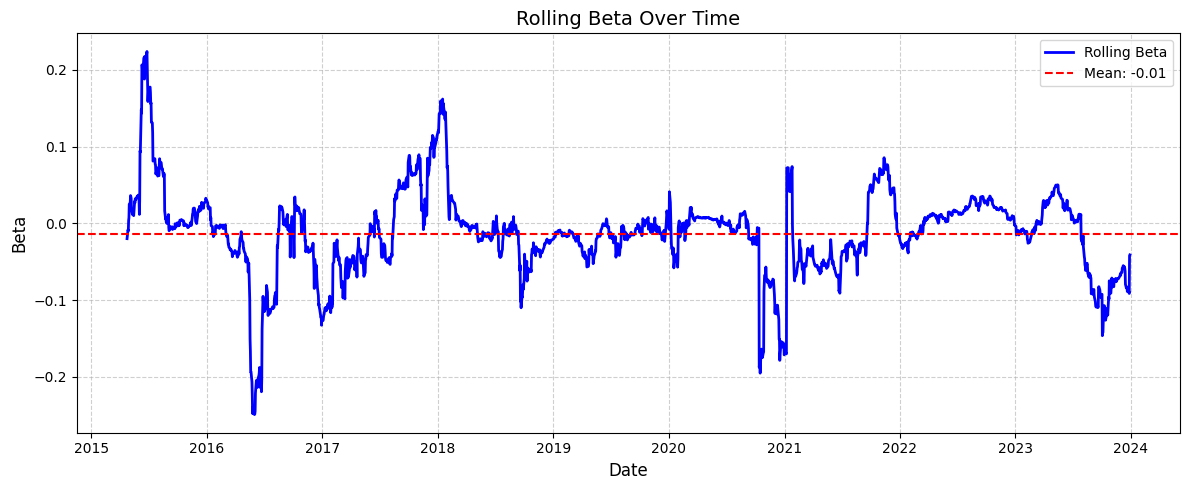

In [54]:
mean_beta = rolling_beta.mean()
plt.figure(figsize=(12, 5))
plt.plot(rolling_beta, label='Rolling Beta', color='blue', linewidth=2)
plt.axhline(mean_beta, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_beta:.2f}')

plt.title('Rolling Beta Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Beta', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

In [55]:
strategy_returns

Date
2015-01-29    0.000000
2015-01-30    0.000000
2015-02-02    0.000000
2015-02-03    0.000000
2015-02-04    0.000000
                ...   
2023-12-22   -0.000812
2023-12-26   -0.000800
2023-12-27   -0.004466
2023-12-28    0.000630
2023-12-29   -0.000244
Length: 2246, dtype: float64

In [56]:
market_returns

,IWV
Date,
2010-01-05,0.002561
2010-01-06,0.001954
2010-01-07,0.003449
2010-01-08,0.003587
2010-01-11,0.000893
...,...
2025-06-17,-0.009362
2025-06-18,0.000207
2025-06-20,-0.001860


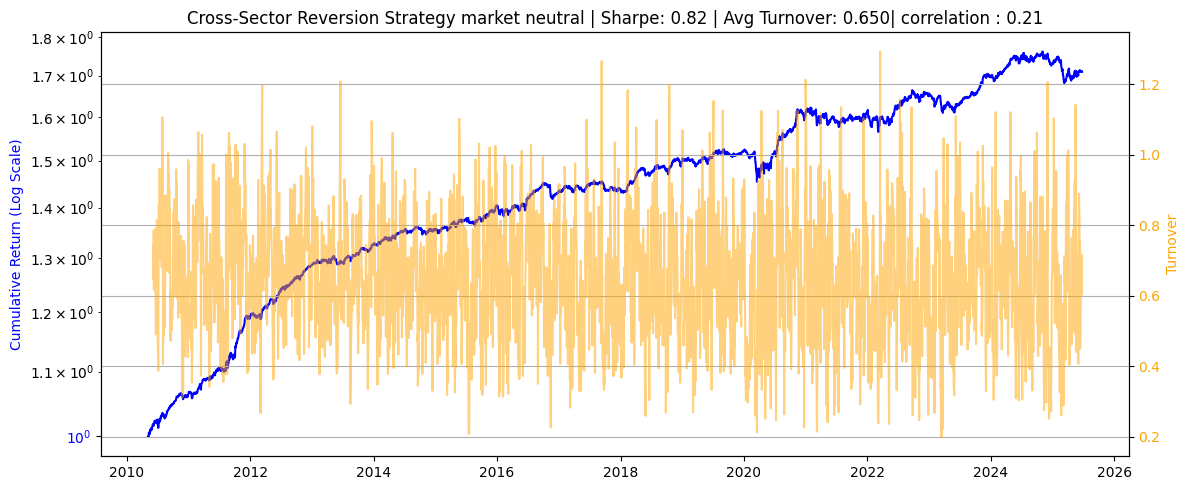

In [57]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

def backtest(df_rets, market_residuals, market_returns, etf_assortment, rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True,
              exponential_weights = True, sector_neutral = True, percentile = True, market_hedged = False, beta_window = 60, weights_clip = False, max_weight = 0.05
              , beta_hedge = False, lag = 1, rolling_window = True, rolling_window_size = 3, corr= True, market_1 = True, beta_neutralize = False):
    
    sector_resid = market_residuals
    if vol_scale:
        vol = sector_resid.rolling(vol_window).std().dropna()
        scaled_sector_resid = sector_resid / (vol + 1e-6)
        cumulative_resid = (1+scaled_sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
        daily_reverse_signal = - cumulative_resid
    else:
        cumulative_resid = (1+sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
        daily_reverse_signal = - cumulative_resid
    
    z_scores_group = daily_reverse_signal.sub(cumulative_resid.mean(axis=1), axis = 0).div(cumulative_resid.std(axis=1), axis = 0)
    if sector_neutral:
        for etfs in etf_assortment:
            z = z_scores_group[etfs]
            z_sector_adj = z.sub(z.mean(axis=1), axis=0)
            z_scores_group[etfs] = z_sector_adj
        z_all = z_scores_group
    else:
        z_all = z_scores_group
    if not percentile:
        z_scores = (z_all.sub(z_all.mean(axis=1), axis  = 0).div(z_all.std(axis=1), axis = 0))
        long_signals = z_scores.clip(lower=0)
        short_signals = z_scores.clip(upper=0)
        
        long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2
        weights = long_weights + short_weights
        if exponential_weights:
            weights = weights.ewm(span=10, adjust=False).mean()

            long_weights = weights.clip(lower=0)
            short_weights = weights.clip(upper=0)

            long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
            short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

            weights = long_weights + short_weights
    else:
        z_scores = (z_all.sub(z_all.mean(axis=1), axis=0)
                  .div(z_all.std(axis=1), axis=0))

        quantile = 0.1
        top_mask = z_scores.ge(z_scores.quantile(1 - quantile, axis=1), axis=0)
        bottom_mask = z_scores.le(z_scores.quantile(quantile, axis=1), axis=0)

        long_signals = z_scores.where(top_mask, 0)
        short_signals = z_scores.where(bottom_mask, 0)
        long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2

        weights = long_weights + short_weights

    if weights_clip:
        max_change = max_weight 

        weights_clipped = weights.copy()
        for t in range(1, len(weights)):
            delta = weights.iloc[t] - weights_clipped.iloc[t - 1]
            delta = delta.clip(lower=-max_change, upper=max_change)
            weights_clipped.iloc[t] = weights_clipped.iloc[t - 1] + delta
        weights = weights_clipped
        long_weights = weights.clip(lower=0)
        short_weights = weights.clip(upper=0)

        long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

        weights = long_weights + short_weights


    # if beta_neutralize:
    #     # compute rolling betas for each ETF
    #     betas = compute_rolling_betas(df_rets, market_returns['IWV'], beta_window)
    #     # align weights & betas on common dates
    #     common = weights.index.intersection(betas.index)
    #     w = weights.loc[common]
    #     b = betas.loc[common, w.columns]
    #     # neutralize
    #     weights = neutralize_beta(w, b)



    
    df_rets.index = pd.to_datetime(df_rets.index)
    weights.index = pd.to_datetime(weights.index)
    if vol_scale:
        common_dates = weights.index.intersection(df_rets.index).intersection(vol.index)
    else:
        common_dates = weights.index.intersection(df_rets.index)
    weights = weights.loc[common_dates]
    df_rets = df_rets.loc[common_dates]
    
    turnover = pd.Series(index=weights.index, dtype=float)

    if rolling_window:
        weights = weights.rolling(window = rolling_window_size).mean()
        

    # avg_turnover = compute_turnover_accurate(weights, df_rets)

    turnover = pd.Series(index=weights.index, dtype=float)

    for t in range(vol_window, len(weights)):
        prev = weights.iloc[t - 1]
        curr = weights.iloc[t]
        turnover.iloc[t] = (curr - prev).abs().sum()

    avg_turnover = turnover.dropna().mean()
    strategy_returns = (weights.shift(lag) * df_rets).sum(axis=1)
    if beta_hedge: 
        aligned_returns = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned_returns.columns = ['strategy', 'market']
        # Set rolling window
        window = 60  # 60 day
        # Add constant for intercept in regression
        X = sm.add_constant(aligned_returns['market'])
        y = aligned_returns['strategy']
        rolling_ols = RollingOLS(endog=y, exog=X, window=window)
        rolling_res = rolling_ols.fit()
        rolling_beta = rolling_res.params['market']
        # Align beta with strategy_returns and calculate residuals
        beta_aligned = rolling_beta.shift(1)  # Avoid look-ahead bias
        strategy_neutralized = aligned_returns['strategy'] - beta_aligned * aligned_returns['market']
        strategy_neutralized.name = 'strategy_beta_neutral'
        strategy_returns = strategy_neutralized
    if not market_hedged:
        same_date = strategy_returns.index.intersection(rf_daily.index)
        sharpe = ((strategy_returns[same_date] - rf_daily[same_date]).mean()) / strategy_returns.std() * np.sqrt(252)
    else:
        window = beta_window
        aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned.columns = ['strategy', 'market']
        rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
        if not market_1:
            hedged_returns = aligned['strategy'] - rolling_beta * aligned['market']

        else:
            hedged_returns = aligned['strategy'] + (1- rolling_beta ) * aligned['market']
        strategy_returns = hedged_returns
        same_date = strategy_returns.index.intersection(rf_daily.index)
        sharpe = ((strategy_returns[same_date] - rf_daily[same_date]).mean()) / strategy_returns.std() * np.sqrt(252)
    if corr:
        window = 60
        aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned.columns = ['strategy', 'market']
        rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
        aligned = aligned.iloc[1:]
        corr = aligned.corr().iloc[0,1]
        
    # if plot_true:
    #     cum_returns = (1 + strategy_returns).cumprod()
    #     fig, ax1 = plt.subplots(figsize=(12, 5))

    #     ax1.plot(cum_returns, color='blue', label='Cumulative Return')
    #     ax1.set_ylabel('Cumulative Return', color='blue')
    #     ax1.tick_params(axis='y', labelcolor='blue')

    #     ax2 = ax1.twinx()
    #     ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
    #     ax2.set_ylabel('Turnover', color='orange')
    #     ax2.tick_params(axis='y', labelcolor='orange')

    #     plt.title(f'Cross-Sector Reversion Strategy | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}')
    #     fig.tight_layout()
    #     plt.grid(True)
    #     plt.show()
        
    if plot_true:
        cum_returns = (1 + strategy_returns).cumprod()
        fig, ax1 = plt.subplots(figsize=(12, 5))

        ax1.plot(cum_returns, color='blue', label='Cumulative Return')
        ax1.set_ylabel('Cumulative Return (Log Scale)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_yscale("log")

        ax2 = ax1.twinx()
        ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
        ax2.set_ylabel('Turnover', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        plt.title(f'Cross-Sector Reversion Strategy market neutral | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}'
                  f'| correlation : {corr:.2f}')
        fig.tight_layout()
        plt.grid(True)
        plt.show()

        return (long_weights,short_weights,weights,strategy_returns)
    
(long_weights,short_weights,weights,strategy_returns) = backtest(df_rets, market_residuals,market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = True, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 40, beta_hedge=False, rolling_window = False, rolling_window_size=4, beta_neutralize= True)


In [58]:
def compute_rolling_betas(df_rets, market_series, window):
    """
    df_rets: (T×N) DataFrame of 자산 i 수익률
    market_series: (T,) Series of 시장 수익률 (e.g. IWV)
    window: int, rolling 윈도우 길이 (예: 60)
    returns: (T×N) DataFrame of rolling betas
    """
    # 1) 자산-시장 공분산 행렬: shape (T, N)
    cov = df_rets.rolling(window).cov(market_series)
    
    # 2) 시장 분산: shape (T,)
    var = market_series.rolling(window).var()
    
    # 3) beta 계산: 각 시점 t에서 cov[t,i] / var[t]
    betas = cov.div(var, axis=0)
    return betas
betas = compute_rolling_betas(df_rets, market_returns['IWV'], 60)

In [59]:
betas

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,0.775501,0.806408,0.980537,0.809194,0.899550,0.911555,0.752873,0.834457,0.547715,0.626592,...,1.002956,1.000086,1.034111,1.092702,1.109897,0.869278,1.168958,0.747245,0.745955,0.908222
2025-06-18,0.776795,0.805551,0.976306,0.809202,0.897084,0.907143,0.754092,0.836728,0.555896,0.635718,...,0.994639,0.993463,1.030677,1.084701,1.109817,0.869610,1.168857,0.748183,0.745499,0.905708
2025-06-20,0.776283,0.805308,0.976085,0.808937,0.896842,0.907458,0.753795,0.836335,0.556451,0.636258,...,0.994687,0.993153,1.030487,1.084427,1.109695,0.869547,1.169303,0.748038,0.745401,0.905234


In [60]:
import numpy as np
import pandas as pd

def neutralize_cash_beta_df(
    weights: pd.DataFrame,
    beta: pd.DataFrame,
    keep_l1_norm: bool = True,
    cond_thresh: float = 1e12,
    cash_only_when_singular: bool = True,
) -> tuple[pd.DataFrame, list]:
    """
    weights, beta: (T×N) DataFrame, 열은 티커, 인덱스는 날짜.
    날짜별로 cash & beta 중립화한 가중치 DataFrame과
    (선택적으로 cash만 중립 처리된) '특이한 날짜' 리스트를 반환.
    """
    # 공통 열/행 정렬
    W, B = weights.align(beta, axis=1, join="inner")
    W, B = W.align(B, axis=0, join="inner")

    out = pd.DataFrame(0.0, index=W.index, columns=W.columns)
    singular_dates = []

    for t, w in W.iterrows():
        b = B.loc[t]
        mask = w.notna() & b.notna()
        k = int(mask.sum())
        if k < 2:
            # 제약(1, beta) 대비 자유도가 부족 → 0으로 둠
            continue

        wv = w[mask].to_numpy(float)
        bv = b[mask].to_numpy(float)
        U = np.column_stack([np.ones(k), bv])  # [1, beta_t] (k×2)

        # 수치 안정성 점검
        M = U.T @ U
        try:
            # 상태수 확인 (ill-conditioned이면 cash-only fallback)
            if np.linalg.cond(M) > cond_thresh:
                raise np.linalg.LinAlgError("ill-conditioned")

            a = np.linalg.solve(M, U.T @ wv)   # (2,)
            wn = wv - U @ a                    # 정사영 성분 제거
        except np.linalg.LinAlgError:
            singular_dates.append(t)
            if cash_only_when_singular:
                wn = wv - wv.mean()            # cash-neutral만 수행
            else:
                # 계산 불가 → 원래 값 유지(0으로 나둠)
                continue

        if keep_l1_norm:
            s_raw = np.abs(wv).sum()
            s_neu = np.abs(wn).sum()
            if s_neu > 0:
                wn *= (s_raw / s_neu)

        out.loc[t, mask] = wn

    return out, singular_dates


def neutrality_report(w_neu: pd.DataFrame, beta: pd.DataFrame) -> pd.DataFrame:
    # 공통 정렬 + 결측 0 처리
    W, B = w_neu.align(beta, axis=1, join="inner")
    W = W.fillna(0.0); B = B.fillna(0.0)
    cash_exp = W.sum(axis=1)
    beta_exp = (W * B).sum(axis=1)
    return pd.DataFrame({"cash_exposure": cash_exp, "beta_exposure": beta_exp})

def assert_neutral(w_neu: pd.DataFrame, beta: pd.DataFrame, atol: float = 1e-10):
    rep = neutrality_report(w_neu, beta)
    max_cash = rep["cash_exposure"].abs().max()
    max_beta = rep["beta_exposure"].abs().max()
    msg = f"Max|cash|={max_cash:.3e}, Max|beta|={max_beta:.3e}, tol={atol}"
    if (max_cash <= atol) and (max_beta <= atol):
        print("OK:", msg)
    else:
        raise AssertionError("Not neutral: " + msg)


# 중립화
w_neu, bad_dates = neutralize_cash_beta_df(weights, betas, keep_l1_norm=True)

# 리포트 확인
rep = neutrality_report(w_neu, betas)
print(rep.tail())       # 최근 며칠 노출
print(rep.describe())   # 노출 통계

# 단언(허용 오차 내 중립이면 OK 출력)
assert_neutral(w_neu, betas, atol=1e-10)

# 특이 날짜(베타가 거의 상수 등) 확인
print("fallback(cash-only) dates:", len(bad_dates), bad_dates[:5])


            cash_exposure  beta_exposure
Date                                    
2025-06-17   1.908196e-17  -2.151057e-16
2025-06-18  -1.665335e-16  -2.081668e-17
2025-06-20  -2.151057e-16   1.318390e-16
2025-06-23   3.955170e-16   1.353084e-16
2025-06-24   6.938894e-17   3.538836e-16
       cash_exposure  beta_exposure
count   3.806000e+03   3.891000e+03
mean   -1.171101e-17   6.818148e-18
std     4.578156e-16   6.140952e-16
min    -3.420007e-15  -4.732326e-15
25%    -1.643650e-16  -1.878380e-16
50%    -9.757820e-19   0.000000e+00
75%     1.457168e-16   1.945059e-16
max     2.949030e-15   4.479056e-15
OK: Max|cash|=3.420e-15, Max|beta|=4.732e-15, tol=1e-10
fallback(cash-only) dates: 0 []


In [61]:
w_neu.max(axis=1)

Date
2010-05-07    0.035455
2010-05-10    0.073130
2010-05-11    0.059172
2010-05-12    0.050467
2010-05-13    0.035886
                ...   
2025-06-17    0.102777
2025-06-18    0.114287
2025-06-20    0.070484
2025-06-23    0.063967
2025-06-24    0.064155
Length: 3806, dtype: float64

In [62]:
strategy_returns = (w_neu.shift(1) * df_rets).sum(axis=1)

<Axes: xlabel='Date'>

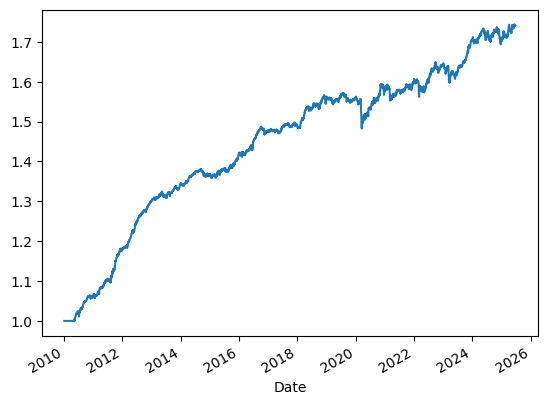

In [63]:
(1+strategy_returns).cumprod().plot()

In [64]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

def backtest(df_rets, market_residuals, market_returns, etf_assortment, rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True,
              exponential_weights = True, sector_neutral = True, percentile = True, market_hedged = False, beta_window = 60, weights_clip = False, max_weight = 0.05
              , beta_hedge = False, lag = 1, rolling_window = True, rolling_window_size = 3, corr= True, market_1 = True, beta_neutralize = False, w_nue = False):
    
    sector_resid = market_residuals
    if vol_scale:
        vol = sector_resid.rolling(vol_window).std().dropna()
        scaled_sector_resid = sector_resid / (vol + 1e-6)
        cumulative_resid = (1+scaled_sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
        daily_reverse_signal = - cumulative_resid
    else:
        cumulative_resid = (1+sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
        daily_reverse_signal = - cumulative_resid
    
    z_scores_group = daily_reverse_signal.sub(cumulative_resid.mean(axis=1), axis = 0).div(cumulative_resid.std(axis=1), axis = 0)
    if sector_neutral:
        for etfs in etf_assortment:
            z = z_scores_group[etfs]
            z_sector_adj = z.sub(z.mean(axis=1), axis=0)
            z_scores_group[etfs] = z_sector_adj
        z_all = z_scores_group
    else:
        z_all = z_scores_group
    if not percentile:
        z_scores = (z_all.sub(z_all.mean(axis=1), axis  = 0).div(z_all.std(axis=1), axis = 0))
        long_signals = z_scores.clip(lower=0)
        short_signals = z_scores.clip(upper=0)
        
        long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2
        weights = long_weights + short_weights
        if exponential_weights:
            weights = weights.ewm(span=10, adjust=False).mean()

            long_weights = weights.clip(lower=0)
            short_weights = weights.clip(upper=0)

            long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
            short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

            weights = long_weights + short_weights
    else:
        z_scores = (z_all.sub(z_all.mean(axis=1), axis=0)
                  .div(z_all.std(axis=1), axis=0))

        quantile = 0.1
        top_mask = z_scores.ge(z_scores.quantile(1 - quantile, axis=1), axis=0)
        bottom_mask = z_scores.le(z_scores.quantile(quantile, axis=1), axis=0)

        long_signals = z_scores.where(top_mask, 0)
        short_signals = z_scores.where(bottom_mask, 0)
        long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2

        weights = long_weights + short_weights

    if weights_clip:
        max_change = max_weight 

        weights_clipped = weights.copy()
        for t in range(1, len(weights)):
            delta = weights.iloc[t] - weights_clipped.iloc[t - 1]
            delta = delta.clip(lower=-max_change, upper=max_change)
            weights_clipped.iloc[t] = weights_clipped.iloc[t - 1] + delta
        weights = weights_clipped
        long_weights = weights.clip(lower=0)
        short_weights = weights.clip(upper=0)

        long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

        weights = long_weights + short_weights


    # if beta_neutralize:
    #     # compute rolling betas for each ETF
    #     betas = compute_rolling_betas(df_rets, market_returns['IWV'], beta_window)
    #     # align weights & betas on common dates
    #     common = weights.index.intersection(betas.index)
    #     w = weights.loc[common]
    #     b = betas.loc[common, w.columns]
    #     # neutralize
    #     weights = neutralize_beta(w, b)


    if not w_nue.empty:
        weights = w_neu
    
    df_rets.index = pd.to_datetime(df_rets.index)
    weights.index = pd.to_datetime(weights.index)
    if vol_scale:
        common_dates = weights.index.intersection(df_rets.index).intersection(vol.index)
    else:
        common_dates = weights.index.intersection(df_rets.index)
    weights = weights.loc[common_dates]
    df_rets = df_rets.loc[common_dates]
    
    turnover = pd.Series(index=weights.index, dtype=float)

    if rolling_window:
        weights = weights.rolling(window = rolling_window_size).mean()
        

    # avg_turnover = compute_turnover_accurate(weights, df_rets)

    turnover = pd.Series(index=weights.index, dtype=float)

    for t in range(vol_window, len(weights)):
        prev = weights.iloc[t - 1]
        curr = weights.iloc[t]
        turnover.iloc[t] = (curr - prev).abs().sum()

    avg_turnover = turnover.dropna().mean()
    strategy_returns = (weights.shift(lag) * df_rets).sum(axis=1)
    if beta_hedge: 
        aligned_returns = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned_returns.columns = ['strategy', 'market']
        # Set rolling window
        window = 60  # 60 day
        # Add constant for intercept in regression
        X = sm.add_constant(aligned_returns['market'])
        y = aligned_returns['strategy']
        rolling_ols = RollingOLS(endog=y, exog=X, window=window)
        rolling_res = rolling_ols.fit()
        rolling_beta = rolling_res.params['market']
        # Align beta with strategy_returns and calculate residuals
        beta_aligned = rolling_beta.shift(1)  # Avoid look-ahead bias
        strategy_neutralized = aligned_returns['strategy'] - beta_aligned * aligned_returns['market']
        strategy_neutralized.name = 'strategy_beta_neutral'
        strategy_returns = strategy_neutralized
    if not market_hedged:
        same_date = strategy_returns.index.intersection(rf_daily.index)
        sharpe = ((strategy_returns[same_date] - rf_daily[same_date]).mean()) / strategy_returns.std() * np.sqrt(252)
    else:
        window = beta_window
        aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned.columns = ['strategy', 'market']
        rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
        if not market_1:
            hedged_returns = aligned['strategy'] - rolling_beta * aligned['market']

        else:
            hedged_returns = aligned['strategy'] + (1- rolling_beta ) * aligned['market']
        strategy_returns = hedged_returns
        same_date = strategy_returns.index.intersection(rf_daily.index)
        sharpe = ((strategy_returns[same_date] - rf_daily[same_date]).mean()) / strategy_returns.std() * np.sqrt(252)
    if corr:
        window = 60
        aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned.columns = ['strategy', 'market']
        rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
        aligned = aligned.iloc[1:]
        corr = aligned.corr().iloc[0,1]
        
    # if plot_true:
    #     cum_returns = (1 + strategy_returns).cumprod()
    #     fig, ax1 = plt.subplots(figsize=(12, 5))

    #     ax1.plot(cum_returns, color='blue', label='Cumulative Return')
    #     ax1.set_ylabel('Cumulative Return', color='blue')
    #     ax1.tick_params(axis='y', labelcolor='blue')

    #     ax2 = ax1.twinx()
    #     ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
    #     ax2.set_ylabel('Turnover', color='orange')
    #     ax2.tick_params(axis='y', labelcolor='orange')

    #     plt.title(f'Cross-Sector Reversion Strategy | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}')
    #     fig.tight_layout()
    #     plt.grid(True)
    #     plt.show()
        
    if plot_true:
        cum_returns = (1 + strategy_returns).cumprod()
        fig, ax1 = plt.subplots(figsize=(12, 5))

        ax1.plot(cum_returns, color='blue', label='Cumulative Return')
        ax1.set_ylabel('Cumulative Return (Log Scale)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_yscale("log")

        ax2 = ax1.twinx()
        ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
        ax2.set_ylabel('Turnover', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        plt.title(f'Cross-Sector Reversion Strategy market neutral | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}'
                  f'| correlation : {corr:.2f}')
        fig.tight_layout()
        plt.grid(True)
        plt.show()

        return (long_weights,short_weights,weights,strategy_returns)

In [65]:
def get_zscores(df_rets, market_residuals, market_returns, etf_assortment, rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True,
              exponential_weights = True, sector_neutral = True, percentile = True, market_hedged = False, beta_window = 60, weights_clip = False, max_weight = 0.05
              , beta_hedge = False, lag = 1, rolling_window = True, rolling_window_size = 3, corr= True, market_1 = True, beta_neutralize = False, w_nue = False):
    
    sector_resid = market_residuals
    if vol_scale:
        vol = sector_resid.rolling(vol_window).std().dropna()
        scaled_sector_resid = sector_resid / (vol + 1e-6)
        cumulative_resid = (1+scaled_sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
        daily_reverse_signal = - cumulative_resid
    else:
        cumulative_resid = (1+sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
        daily_reverse_signal = - cumulative_resid
    
    z_scores_group = daily_reverse_signal.sub(cumulative_resid.mean(axis=1), axis = 0).div(cumulative_resid.std(axis=1), axis = 0)
    if sector_neutral:
        for etfs in etf_assortment:
            z = z_scores_group[etfs]
            z_sector_adj = z.sub(z.mean(axis=1), axis=0)
            z_scores_group[etfs] = z_sector_adj
        z_all = z_scores_group
    else:
        z_all = z_scores_group
    z_scores = (z_all.sub(z_all.mean(axis=1), axis=0)
            .div(z_all.std(axis=1), axis=0))
    return z_scores

In [66]:
z_score = get_zscores(df_rets, market_residuals,market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = True, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 40, beta_hedge=False, rolling_window = False, rolling_window_size=4, beta_neutralize= True, w_nue=w_neu)

In [67]:
z_score.dropna()

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-07,0.446242,0.076922,0.836106,-1.234239,0.320546,0.770577,0.834085,0.009453,-2.351274,-1.847429,...,-0.042287,-0.312295,0.697419,0.270247,0.074422,0.899279,1.431525,-1.135116,0.092076,-1.287764
2010-05-10,1.096851,-1.105149,-0.291896,0.582949,-0.030630,-0.222297,0.370872,0.454475,-0.835304,-1.173362,...,0.101286,0.778450,0.668606,-0.564992,-0.111915,-0.625892,-0.750432,1.028931,-0.116299,0.463692
2010-05-11,-0.006425,0.408933,-0.895855,0.764098,-0.107732,-0.857350,-0.810815,-0.436915,1.218308,2.100143,...,0.019525,-1.367124,-0.926653,0.399734,0.042051,-0.779433,0.379617,0.989463,0.030656,-0.620303
2010-05-12,-1.266641,-1.116792,-1.741977,2.393272,-1.025852,-2.331996,0.913843,1.788454,0.228398,0.944907,...,-0.928905,0.477473,0.723339,-0.309802,0.678458,-1.123469,-0.479256,0.178045,0.903830,0.520850
2010-05-13,-1.524425,0.254938,-0.796160,-0.426295,-1.360061,-0.150805,-0.167151,0.182813,0.794989,1.069107,...,0.181188,0.308669,0.307516,-0.451544,0.518149,-0.774601,1.159381,1.917646,-1.384504,-0.917922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-1.393069,-0.402063,-0.629428,-0.147433,0.211872,-0.665011,-0.487591,0.622985,0.610092,1.461675,...,-0.221872,0.025972,1.562141,-0.584720,0.339362,0.483948,-1.781399,0.962950,0.005965,0.328536
2025-06-18,0.369209,0.037765,-0.735765,-0.570039,-1.189066,-0.792227,0.074793,0.005228,-0.105925,-0.241292,...,-0.103009,-0.364458,0.302103,0.122415,1.541804,3.351304,0.342580,-0.900219,-0.915936,-1.877728
2025-06-20,-0.683592,-0.475617,-0.278461,-0.945980,-0.760970,0.706207,-0.719945,-1.232374,1.822750,1.799549,...,0.296790,-0.415137,-0.250599,-0.197560,0.109926,0.083568,2.799497,-0.713682,-0.706198,-1.463185


In [68]:
w_neu

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-07,0.009767,0.001859,0.018122,-0.026022,0.007121,0.016949,0.017184,0.000191,-0.048763,-0.038524,...,-0.000616,-0.006401,0.014946,0.006144,0.002261,0.019096,0.029736,-0.024552,0.001443,-0.027184
2010-05-10,0.032365,-0.017243,0.013459,-0.007851,0.008993,0.016743,0.014089,0.008845,-0.038702,-0.043112,...,0.004071,0.011974,0.026168,-0.001074,0.007660,0.005002,0.001759,-0.006008,-0.007683,-0.011293
2010-05-11,0.037731,-0.013969,-0.013703,0.011833,0.004165,-0.011102,0.000967,-0.000483,-0.028142,-0.004399,...,0.003250,-0.023778,0.005618,0.004133,0.002892,-0.018745,0.017436,0.028293,-0.002727,-0.030727
2010-05-12,-0.000669,-0.025639,-0.035014,0.050467,-0.013467,-0.042116,0.012015,0.032711,-0.001336,0.020968,...,-0.013112,-0.002792,0.018190,0.001414,0.020875,-0.028357,-0.003192,0.011390,0.010327,-0.007541
2010-05-13,-0.020951,-0.011103,-0.030723,0.023175,-0.025960,-0.026025,0.004548,0.021254,0.010060,0.026504,...,-0.005089,0.002542,0.014513,-0.005364,0.018916,-0.026604,0.013865,0.032472,-0.012694,-0.016563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.060431,0.002680,0.008770,0.003657,0.014546,-0.000766,-0.009653,0.013662,-0.021317,0.016437,...,0.029305,-0.000244,-0.006220,0.012177,-0.034203,0.048735,-0.040265,0.007284,-0.001742,-0.012584
2025-06-18,-0.047402,0.002276,-0.002369,-0.005641,-0.004579,-0.011965,-0.008172,0.011584,-0.022291,0.008908,...,0.024520,-0.004659,0.000242,0.013801,-0.005135,0.090473,-0.027243,-0.007785,-0.015834,-0.037829
2025-06-20,-0.043556,-0.004498,-0.004687,-0.016039,-0.012585,0.000042,-0.015381,-0.006812,0.004528,0.027456,...,0.022138,-0.007960,-0.002179,0.008647,-0.001328,0.067223,0.015723,-0.015045,-0.020857,-0.045495


In [69]:
def compute_rolling_betas(df_rets, market_series, window):

    cov = df_rets.rolling(window).cov(market_series)
    
    var = market_series.rolling(window).var()

    betas = cov.div(var, axis=0)
    return betas

def project_IP_form_cash0_beta1(
    weights: pd.DataFrame,
    beta: pd.DataFrame,
    target_beta: float = 1.0,
    eps: float = 1e-12,
    fallback: str = "cash_only",  # {"cash_only","nan","keep"}
) -> tuple[pd.DataFrame, list]:
    
    W, B = weights.align(beta, axis=1, join="inner")
    W, B = W.align(B, axis=0, join="inner")

    out = pd.DataFrame(0.0, index=W.index, columns=W.columns)
    bad_dates = []

    for t, w in W.iterrows():
        b = B.loc[t]
        mask = w.notna() & b.notna()
        k = int(mask.sum())
        if k == 0:
            continue

        wv = w[mask].to_numpy(float)     # (k,)
        bv = b[mask].to_numpy(float)     # (k,)
        ones = np.ones(k, dtype=float)

        # --- P = U (U^T U)^{-1} U^T,  U=[1, beta]
        UtU = np.array([[k,         bv.sum()],
                        [bv.sum(),  np.dot(bv, bv)]], dtype=float)
        det = UtU[0,0]*UtU[1,1] - UtU[0,1]*UtU[1,0]
        if abs(det) < eps:
            bad_dates.append(t)
            if fallback == "cash_only":
                out.loc[t, mask] = wv - wv.mean()   
            elif fallback == "nan":
                out.loc[t, mask] = np.nan
            elif fallback == "keep":
                out.loc[t, mask] = wv
            continue

        invUtU = (1.0/det) * np.array([[ UtU[1,1], -UtU[0,1]],
                                       [-UtU[1,0],  UtU[0,0]]], dtype=float)
        U      = np.column_stack([ones, bv])       
        Pwv    = U @ (invUtU @ (U.T @ wv))         
        w_orth = wv - Pwv                          

        c = np.array([1.0, float(target_beta)])
        coeff = invUtU @ c             
        u_part = U @ coeff             

        w_star = w_orth + u_part
        out.loc[t, mask] = w_star

    return out, bad_dates


def neutralize_cash_beta_df(
    weights: pd.DataFrame,
    beta: pd.DataFrame,
    keep_l1_norm: bool = True,
    cond_thresh: float = 1e12,
    cash_only_when_singular: bool = True,
) -> tuple[pd.DataFrame, list]:
    
    W, B = weights.align(beta, axis=1, join="inner")
    W, B = W.align(B, axis=0, join="inner")

    out = pd.DataFrame(0.0, index=W.index, columns=W.columns)
    singular_dates = []

    for t, w in W.iterrows():
        b = B.loc[t]
        mask = w.notna() & b.notna()
        k = int(mask.sum())
        if k < 2:
            continue

        wv = w[mask].to_numpy(float)
        bv = b[mask].to_numpy(float)
        U = np.column_stack([np.ones(k), bv])  # [1, beta_t] (k×2)

        M = U.T @ U
        try:

            if np.linalg.cond(M) > cond_thresh:
                raise np.linalg.LinAlgError("ill-conditioned")

            a = np.linalg.solve(M, U.T @ wv)   
            wn = wv - U @ a                    
        except np.linalg.LinAlgError:
            singular_dates.append(t)
            if cash_only_when_singular:
                wn = wv - wv.mean()          
            else:
                continue

        if keep_l1_norm:
            s_raw = np.abs(wv).sum()
            s_neu = np.abs(wn).sum()
            if s_neu > 0:
                wn *= (s_raw / s_neu)

        out.loc[t, mask] = wn

    return out, singular_dates



def backtest(df_rets, market_residuals, market_returns, etf_assortment, rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True,
              exponential_weights = True, sector_neutral = True, percentile = True, market_hedged = False, beta_window = 60, weights_clip = False, max_weight = 0.05
              , beta_hedge = False, lag = 1, rolling_window = True, rolling_window_size = 3, corr= True, market_1 = True, beta_neutralize = False, w_nue = False, beta_0 = True):
    
    sector_resid = market_residuals
    if vol_scale:
        vol = sector_resid.rolling(vol_window).std().dropna()
        scaled_sector_resid = sector_resid / (vol + 1e-6)
        cumulative_resid = (1+scaled_sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
        daily_reverse_signal = - cumulative_resid
    else:
        cumulative_resid = (1+sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
        daily_reverse_signal = - cumulative_resid
    
    z_scores_group = daily_reverse_signal.sub(cumulative_resid.mean(axis=1), axis = 0).div(cumulative_resid.std(axis=1), axis = 0)
    if sector_neutral:
        for etfs in etf_assortment:
            z = z_scores_group[etfs]
            z_sector_adj = z.sub(z.mean(axis=1), axis=0)
            z_scores_group[etfs] = z_sector_adj
        z_all = z_scores_group
    else:
        z_all = z_scores_group

    z_scores = (z_all.sub(z_all.mean(axis=1), axis  = 0).div(z_all.std(axis=1), axis = 0))
    long_signals = z_scores.clip(lower=0)
    short_signals = z_scores.clip(upper=0)
    long_signals = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0)
    short_signals = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) 
    z_scores = long_signals + short_signals
    long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
    short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2
    if not beta_0:
        long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1.5
        short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2
    weights = long_weights + short_weights
    if exponential_weights:
        weights = weights.ewm(span=10, adjust=False).mean()

        long_weights = weights.clip(lower=0)
        short_weights = weights.clip(upper=0)
        if beta_0:
            long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
            short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2
        elif not beta_0:
            long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1.5
            short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

        weights = long_weights + short_weights

    #     quantile = 0.1
    #     top_mask = z_scores.ge(z_scores.quantile(1 - quantile, axis=1), axis=0)
    #     bottom_mask = z_scores.le(z_scores.quantile(quantile, axis=1), axis=0)

    #     long_signals = z_scores.where(top_mask, 0)
    #     short_signals = z_scores.where(bottom_mask, 0)
    #     long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
    #     short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2

    #     weights = long_weights + short_weights

    # if weights_clip:
    #     max_change = max_weight 

    #     weights_clipped = weights.copy()
    #     for t in range(1, len(weights)):
    #         delta = weights.iloc[t] - weights_clipped.iloc[t - 1]
    #         delta = delta.clip(lower=-max_change, upper=max_change)
    #         weights_clipped.iloc[t] = weights_clipped.iloc[t - 1] + delta
    #     weights = weights_clipped
    #     long_weights = weights.clip(lower=0)
    #     short_weights = weights.clip(upper=0)

    #     long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
    #     short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

    #     weights = long_weights + short_weights


    # if beta_neutralize:
    #     # compute rolling betas for each ETF
    #     betas = compute_rolling_betas(df_rets, market_returns['IWV'], beta_window)
    #     # align weights & betas on common dates
    #     common = weights.index.intersection(betas.index)
    #     w = weights.loc[common]
    #     b = betas.loc[common, w.columns]
    #     # neutralize
    #     weights = neutralize_beta(w, b)
    betas = compute_rolling_betas(df_rets, market_returns['IWV'], 60)
    if beta_0:
        w_proj, bad = neutralize_cash_beta_df(weights, betas)
        weights = w_proj
            
        long_weights = weights.clip(lower=0)
        short_weights = weights.clip(upper=0)

        long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

        weights = long_weights + short_weights
    else:
        w_proj, bad = project_IP_form_cash0_beta1(weights,betas)
        weights = w_proj
    
        long_weights = weights.clip(lower=0)
        short_weights = weights.clip(upper=0)

        long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1.1
        short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/10

        weights = long_weights + short_weights
    
    df_rets.index = pd.to_datetime(df_rets.index)
    weights.index = pd.to_datetime(weights.index)
    if vol_scale:
        common_dates = weights.index.intersection(df_rets.index).intersection(vol.index)
    else:
        common_dates = weights.index.intersection(df_rets.index)
    weights = weights.loc[common_dates]
    df_rets = df_rets.loc[common_dates]
    

    ## weights scaling 한 부분이다.
    # if not percentile:
    #     long_signals = weights.clip(lower=0)
    #     short_signals = weights.clip(upper=0)
    #     long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
    #     short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2
    #     weights = long_weights + short_weights
    #     if exponential_weights:
    #         weights = weights.ewm(span=10, adjust=False).mean()

    #         long_weights = weights.clip(lower=0)
    #         short_weights = weights.clip(upper=0)

    #         long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
    #         short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

    #         weights = long_weights + short_weights







    turnover = pd.Series(index=weights.index, dtype=float)

    if rolling_window:
        weights = weights.rolling(window = rolling_window_size).mean()
        

    # avg_turnover = compute_turnover_accurate(weights, df_rets)

    turnover = pd.Series(index=weights.index, dtype=float)

    for t in range(vol_window, len(weights)):
        prev = weights.iloc[t - 1]
        curr = weights.iloc[t]
        turnover.iloc[t] = (curr - prev).abs().sum()

    avg_turnover = turnover.dropna().mean()
    strategy_returns = (weights.shift(lag) * df_rets).sum(axis=1)
    if beta_hedge: 
        aligned_returns = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned_returns.columns = ['strategy', 'market']
        # Set rolling window
        window = 60  # 60 day
        # Add constant for intercept in regression
        X = sm.add_constant(aligned_returns['market'])
        y = aligned_returns['strategy']
        rolling_ols = RollingOLS(endog=y, exog=X, window=window)
        rolling_res = rolling_ols.fit()
        rolling_beta = rolling_res.params['market']
        # Align beta with strategy_returns and calculate residuals
        beta_aligned = rolling_beta.shift(1)  # Avoid look-ahead bias
        strategy_neutralized = aligned_returns['strategy'] - beta_aligned * aligned_returns['market']
        strategy_neutralized.name = 'strategy_beta_neutral'
        strategy_returns = strategy_neutralized
    if not market_hedged:
        same_date = strategy_returns.index.intersection(rf_daily.index)
        sharpe = ((strategy_returns[same_date] - rf_daily[same_date]).mean()) / strategy_returns.std() * np.sqrt(252)
    else:
        window = beta_window
        aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned.columns = ['strategy', 'market']
        rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
        if not market_1:
            hedged_returns = aligned['strategy'] - rolling_beta * aligned['market']

        else:
            hedged_returns = aligned['strategy'] + (1- rolling_beta ) * aligned['market']
        strategy_returns = hedged_returns
        same_date = strategy_returns.index.intersection(rf_daily.index)
        sharpe = ((strategy_returns[same_date] - rf_daily[same_date]).mean()) / strategy_returns.std() * np.sqrt(252)
    if corr:
        window = 60
        aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned.columns = ['strategy', 'market']
        rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
        aligned = aligned.iloc[1:]
        corr = aligned.corr().iloc[0,1]
        
    # if plot_true:
    #     cum_returns = (1 + strategy_returns).cumprod()
    #     fig, ax1 = plt.subplots(figsize=(12, 5))

    #     ax1.plot(cum_returns, color='blue', label='Cumulative Return')
    #     ax1.set_ylabel('Cumulative Return', color='blue')
    #     ax1.tick_params(axis='y', labelcolor='blue')

    #     ax2 = ax1.twinx()
    #     ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
    #     ax2.set_ylabel('Turnover', color='orange')
    #     ax2.tick_params(axis='y', labelcolor='orange')

    #     plt.title(f'Cross-Sector Reversion Strategy | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}')
    #     fig.tight_layout()
    #     plt.grid(True)
    #     plt.show()
        
    if plot_true and beta_0:
        cum_returns = (1 + strategy_returns).cumprod()
        fig, ax1 = plt.subplots(figsize=(12, 5))

        ax1.plot(cum_returns, color='blue', label='Cumulative Return')
        ax1.set_ylabel('Cumulative Return (Log Scale)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_yscale("log")

        ax2 = ax1.twinx()
        ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
        ax2.set_ylabel('Turnover', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        plt.title(f'Cross-Sector Reversion Strategy market neutral | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}'
                  f'| correlation : {corr:.2f}')
        fig.tight_layout()
        plt.grid(True)
        plt.show()


    if plot_true and not beta_0:
        cum_returns = (1 + strategy_returns).cumprod()
        fig, ax1 = plt.subplots(figsize=(12, 5))

        ax1.plot(cum_returns, color='blue', label='Cumulative Return')
        ax1.set_ylabel('Cumulative Return (Log Scale)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_yscale("log")

        ax2 = ax1.twinx()
        ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
        ax2.set_ylabel('Turnover', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        
        plt.title(f'Cross-Sector Reversion Strategy market beta 1 | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}'
                  f'| correlation : {corr:.2f}')
        fig.tight_layout()
        plt.grid(True)
        plt.show()

    return (z_scores, betas,weights,strategy_returns)

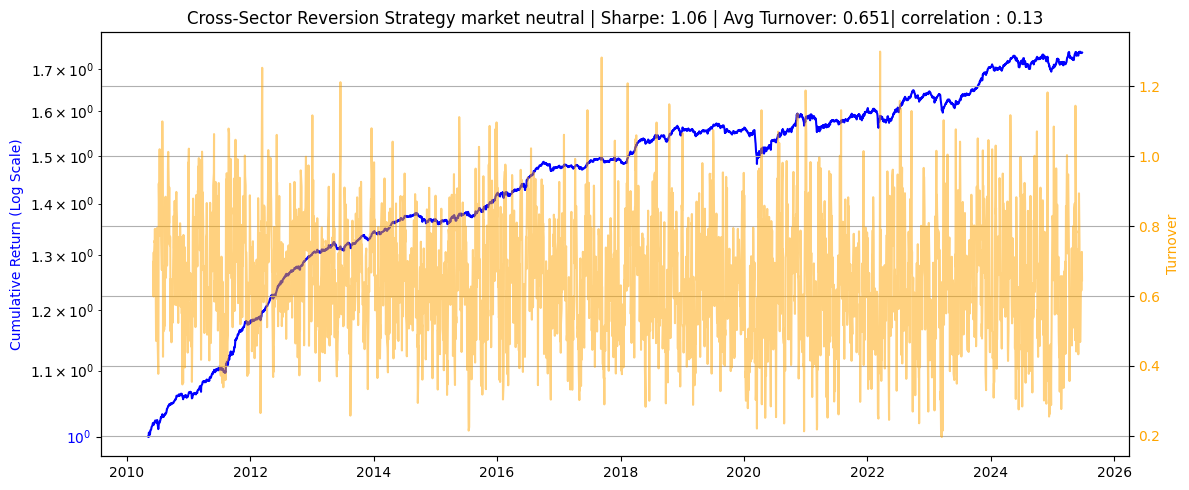

In [79]:
(z_scores,betas,weights,strategy_returns) = backtest(df_rets, market_residuals,market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = True, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 40, beta_hedge=False, rolling_window = False, rolling_window_size=4, beta_neutralize= True, w_nue=w_neu, beta_0 = True)

In [71]:
(weights * betas).dropna().sum(axis=1)

Date
2010-05-07    6.245005e-17
2010-05-10    2.168404e-16
2010-05-11    2.775558e-16
2010-05-12   -6.834810e-16
2010-05-13    6.036838e-16
                  ...     
2025-06-17   -1.838807e-16
2025-06-18    1.804112e-16
2025-06-20    4.718448e-16
2025-06-23   -2.012279e-16
2025-06-24    3.330669e-16
Length: 3806, dtype: float64

In [72]:
weights.clip(lower = 0).sum(axis=1)

Date
2010-05-07    0.5
2010-05-10    0.5
2010-05-11    0.5
2010-05-12    0.5
2010-05-13    0.5
             ... 
2025-06-17    0.5
2025-06-18    0.5
2025-06-20    0.5
2025-06-23    0.5
2025-06-24    0.5
Length: 3806, dtype: float64

In [73]:
(weights * betas).dropna().sum(axis=1).mean()

1.9656753324908386e-17

In [80]:
weights.to_csv("market_neutral_weights.csv")

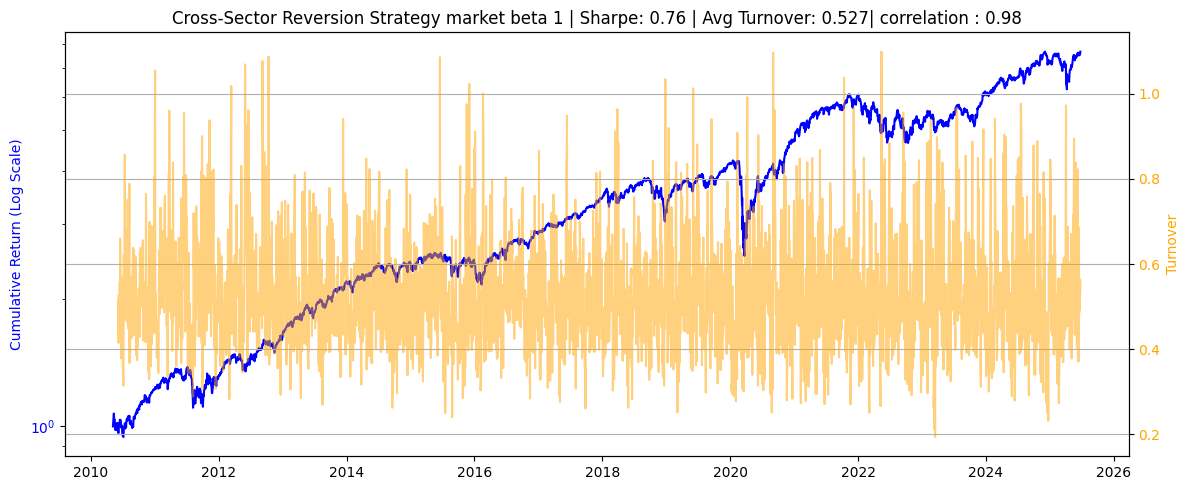

In [81]:
(z_scores,betas,weights,strategy_returns) = backtest(df_rets, market_residuals,market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = True, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 40, beta_hedge=False, rolling_window = False, rolling_window_size=4, beta_neutralize= True, w_nue=w_neu,beta_0 = False)

In [76]:
(weights * betas).dropna().sum(axis=1)

Date
2010-05-07    1.032984
2010-05-10    1.039407
2010-05-11    0.988973
2010-05-12    1.042114
2010-05-13    1.036740
                ...   
2025-06-17    0.967316
2025-06-18    0.953880
2025-06-20    0.942503
2025-06-23    0.935262
2025-06-24    0.923842
Length: 3806, dtype: float64

In [77]:
weights.sum(axis=1)

Date
2010-05-07    1.0
2010-05-10    1.0
2010-05-11    1.0
2010-05-12    1.0
2010-05-13    1.0
             ... 
2025-06-17    1.0
2025-06-18    1.0
2025-06-20    1.0
2025-06-23    1.0
2025-06-24    1.0
Length: 3806, dtype: float64

In [83]:
weights.clip(lower = 0).max(axis=1)

Date
2010-05-07    0.079608
2010-05-10    0.129088
2010-05-11    0.091132
2010-05-12    0.067877
2010-05-13    0.061606
                ...   
2025-06-17    0.102200
2025-06-18    0.103554
2025-06-20    0.080983
2025-06-23    0.060699
2025-06-24    0.074287
Length: 3806, dtype: float64

NameError: name 'sharpe' is not defined

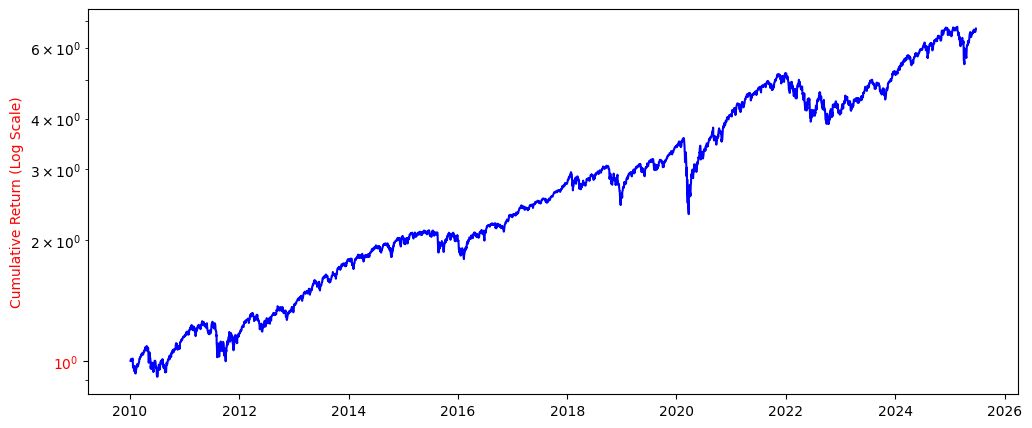

In [84]:
cum_returns = (1+market_returns).cumprod()
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(cum_returns, color='blue', label='Cumulative Return')
ax1.set_ylabel('Cumulative Return (Log Scale)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_yscale("log")



plt.title(f'russel 2000 market index ( IWV ) and Sharepe is {sharpe:.2f}')
fig.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
market_returns['IWV']

Date
2010-01-05    0.002561
2010-01-06    0.001954
2010-01-07    0.003449
2010-01-08    0.003587
2010-01-11    0.000893
                ...   
2025-06-17   -0.009362
2025-06-18    0.000207
2025-06-20   -0.001860
2025-06-23    0.009821
2025-06-24    0.008729
Name: IWV, Length: 3891, dtype: float64

In [ ]:
same_date = market_returns['IWV'].index.intersection(rf_daily.index)
sharpe = ((market_returns['IWV'][same_date] - rf_daily[same_date]).mean()) / market_returns['IWV'].std() * np.sqrt(252)

In [ ]:
sharpe

0.7078510773665545

In [85]:
market_returns.index

DatetimeIndex(['2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14',
               '2010-01-15', '2010-01-19',
               ...
               '2025-06-10', '2025-06-11', '2025-06-12', '2025-06-13',
               '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-20',
               '2025-06-23', '2025-06-24'],
              dtype='datetime64[ns]', name='Date', length=3891, freq=None)

In [86]:
rf_daily.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2025-07-21', '2025-07-22', '2025-07-23', '2025-07-24',
               '2025-07-25', '2025-07-28', '2025-07-29', '2025-07-30',
               '2025-07-31', '2025-08-01'],
              dtype='datetime64[ns]', name='Date', length=3917, freq=None)

In [87]:
rf_daily[same_date]

NameError: name 'same_date' is not defined

In [88]:
market_returns.index.intersection(rf_daily.index)

DatetimeIndex(['2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14',
               '2010-01-15', '2010-01-19',
               ...
               '2025-06-10', '2025-06-11', '2025-06-12', '2025-06-13',
               '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-20',
               '2025-06-23', '2025-06-24'],
              dtype='datetime64[ns]', name='Date', length=3889, freq=None)

In [89]:
market_returns.loc[market_returns.index.intersection(rf_daily.index) , :]

,IWV
Date,
2010-01-05,0.002561
2010-01-06,0.001954
2010-01-07,0.003449
2010-01-08,0.003587
2010-01-11,0.000893
...,...
2025-06-17,-0.009362
2025-06-18,0.000207
2025-06-20,-0.001860


In [90]:
weights.to_csv("market_beta1_weights.csv")

In [91]:
(weights * betas).dropna().sum(axis=1).mean()

0.987192819963507

In [92]:
(weights * betas).dropna().sum(axis=1)

Date
2010-05-07    1.032984
2010-05-10    1.039407
2010-05-11    0.988973
2010-05-12    1.042114
2010-05-13    1.036740
                ...   
2025-06-17    0.967316
2025-06-18    0.953880
2025-06-20    0.942503
2025-06-23    0.935262
2025-06-24    0.923842
Length: 3806, dtype: float64

In [93]:
(weights * betas).dropna()

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-07,0.021570,0.001941,0.044125,-0.005429,0.014487,0.040682,0.037969,0.000530,-0.015865,-0.010534,...,-0.000909,-0.001927,0.035413,0.011157,-0.000752,0.045622,0.062485,-0.002733,0.007108,-0.005512
2010-05-10,0.061444,-0.004848,0.031724,0.008816,0.015593,0.036729,0.024693,0.016069,-0.015626,-0.015762,...,0.006798,0.027428,0.048454,0.008865,0.013211,0.023800,0.021306,0.012187,-0.001512,0.003807
2010-05-11,0.037196,0.000667,0.000732,0.028094,0.001584,-0.000652,0.019082,0.007940,0.001118,0.036738,...,0.000916,0.004537,0.021668,0.008092,-0.001686,0.002387,0.031015,0.040198,0.005507,-0.005905
2010-05-12,0.018127,-0.009009,-0.014775,0.070502,-0.006357,-0.023625,0.022820,0.044598,0.027505,0.060367,...,-0.007397,0.015558,0.033986,0.010668,0.026953,-0.007553,0.012517,0.021328,0.014368,0.009512
2010-05-13,0.000542,0.002425,-0.013844,0.046055,-0.013705,-0.013142,0.014977,0.034492,0.039631,0.067032,...,0.001249,0.016917,0.029643,0.003452,0.030747,-0.009642,0.028857,0.043652,0.002734,0.000795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.026361,0.008533,0.029109,0.004736,0.022068,0.019713,-0.000263,0.014470,-0.001698,0.011122,...,0.044380,0.015642,0.028160,0.037816,-0.004714,0.047824,-0.017967,0.012582,0.001866,0.009367
2025-06-18,-0.025770,0.006806,0.020132,0.001539,0.012848,0.012400,-0.000105,0.011439,-0.001438,0.007751,...,0.034464,0.011038,0.026748,0.032038,0.033155,0.074626,-0.007098,0.006641,-0.000471,-0.008409
2025-06-20,-0.017204,0.004107,0.015183,-0.000433,0.007726,0.017747,-0.000600,0.005263,0.007660,0.020260,...,0.031473,0.007170,0.020540,0.024922,0.028103,0.061771,0.052407,0.003437,-0.000884,-0.020780


In [94]:
weights

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-07,0.017766,0.001669,0.034698,-0.005136,0.011923,0.030013,0.041718,0.000499,-0.011532,-0.008605,...,-0.000772,-0.001694,0.030289,0.008938,-0.000559,0.040461,0.069660,-0.003384,0.008213,-0.005285
2010-05-10,0.052466,-0.004125,0.025265,0.008397,0.012956,0.027443,0.027599,0.015198,-0.010642,-0.011980,...,0.005933,0.024892,0.042902,0.007127,0.010011,0.020213,0.023075,0.015165,-0.001727,0.003649
2010-05-11,0.031799,0.000567,0.000584,0.026758,0.001317,-0.000489,0.021433,0.007516,0.000760,0.027821,...,0.000801,0.004139,0.019272,0.006517,-0.001281,0.002034,0.033583,0.049973,0.006291,-0.005665
2010-05-12,0.015430,-0.007668,-0.011736,0.067877,-0.005283,-0.017434,0.026672,0.042630,0.019074,0.046751,...,-0.006372,0.014101,0.030145,0.008490,0.020403,-0.006435,0.013508,0.026934,0.016565,0.009184
2010-05-13,0.000465,0.002067,-0.011072,0.044389,-0.011440,-0.009746,0.017629,0.032976,0.027591,0.052025,...,0.001085,0.015436,0.026480,0.002778,0.023442,-0.008256,0.031132,0.054732,0.003152,0.000767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.033993,0.010582,0.029686,0.005853,0.024532,0.021626,-0.000349,0.017340,-0.003100,0.017750,...,0.044250,0.015641,0.027231,0.034607,-0.004247,0.055016,-0.015370,0.016837,0.002501,0.010314
2025-06-18,-0.033175,0.008449,0.020621,0.001902,0.014322,0.013669,-0.000140,0.013671,-0.002586,0.012193,...,0.034650,0.011111,0.025951,0.029536,0.029874,0.085816,-0.006072,0.008876,-0.000632,-0.009285
2025-06-20,-0.022162,0.005100,0.015555,-0.000536,0.008615,0.019557,-0.000795,0.006293,0.013766,0.031843,...,0.031641,0.007219,0.019933,0.022982,0.025325,0.071038,0.044819,0.004594,-0.001186,-0.022955


In [95]:
betas

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,0.775501,0.806408,0.980537,0.809194,0.899550,0.911555,0.752873,0.834457,0.547715,0.626592,...,1.002956,1.000086,1.034111,1.092702,1.109897,0.869278,1.168958,0.747245,0.745955,0.908222
2025-06-18,0.776795,0.805551,0.976306,0.809202,0.897084,0.907143,0.754092,0.836728,0.555896,0.635718,...,0.994639,0.993463,1.030677,1.084701,1.109817,0.869610,1.168857,0.748183,0.745499,0.905708
2025-06-20,0.776283,0.805308,0.976085,0.808937,0.896842,0.907458,0.753795,0.836335,0.556451,0.636258,...,0.994687,0.993153,1.030487,1.084427,1.109695,0.869547,1.169303,0.748038,0.745401,0.905234


In [96]:
(weights * betas).dropna().sum(axis = 1)

Date
2010-05-07    1.032984
2010-05-10    1.039407
2010-05-11    0.988973
2010-05-12    1.042114
2010-05-13    1.036740
                ...   
2025-06-17    0.967316
2025-06-18    0.953880
2025-06-20    0.942503
2025-06-23    0.935262
2025-06-24    0.923842
Length: 3806, dtype: float64

In [97]:
import numpy as np
import pandas as pd

def project_IP_form_cash0_beta1(
    weights: pd.DataFrame,
    beta: pd.DataFrame,
    target_beta: float = 1.0,
    eps: float = 1e-12,
    fallback: str = "cash_only",  # {"cash_only","nan","keep"}
) -> tuple[pd.DataFrame, list]:
    """
    w* = (I - P) w0 + u_part  형태로 구현:
      - P: span{1, beta}에 대한 정사영
      - u_part = A^T (AA^T)^{-1} c  (c=[0, target_beta])

    제약: sum(w*)=0, sum(beta*w*)=target_beta  (수치 오차 제외 정확 만족)
    (1, beta)가 거의 평행(랭크 1)인 날짜는 fallback 적용.
    """
    # 공통 정렬
    W, B = weights.align(beta, axis=1, join="inner")
    W, B = W.align(B, axis=0, join="inner")

    out = pd.DataFrame(0.0, index=W.index, columns=W.columns)
    bad_dates = []

    for t, w in W.iterrows():
        b = B.loc[t]
        mask = w.notna() & b.notna()
        k = int(mask.sum())
        if k == 0:
            continue

        wv = w[mask].to_numpy(float)     # (k,)
        bv = b[mask].to_numpy(float)     # (k,)
        ones = np.ones(k, dtype=float)

        # --- P = U (U^T U)^{-1} U^T,  U=[1, beta]
        UtU = np.array([[k,         bv.sum()],
                        [bv.sum(),  np.dot(bv, bv)]], dtype=float)
        det = UtU[0,0]*UtU[1,1] - UtU[0,1]*UtU[1,0]
        if abs(det) < eps:
            # (1, beta) 선형종속 → 두 제약 동시 만족 불가
            bad_dates.append(t)
            if fallback == "cash_only":
                out.loc[t, mask] = wv - wv.mean()   # sum=0만
            elif fallback == "nan":
                out.loc[t, mask] = np.nan
            elif fallback == "keep":
                out.loc[t, mask] = wv
            continue

        invUtU = (1.0/det) * np.array([[ UtU[1,1], -UtU[0,1]],
                                       [-UtU[1,0],  UtU[0,0]]], dtype=float)
        U      = np.column_stack([ones, bv])          # (k×2)
        Pwv    = U @ (invUtU @ (U.T @ wv))            # P w0
        w_orth = wv - Pwv                              # (I - P) w0

        # --- u_part = A^T (AA^T)^{-1} c = U @ ( (U^T U)^{-1} @ [0, target_beta] )
        c = np.array([0.0, float(target_beta)])
        coeff = invUtU @ c              # [alpha, gamma]
        u_part = U @ coeff              # alpha*1 + gamma*beta

        w_star = w_orth + u_part
        out.loc[t, mask] = w_star

    return out, bad_dates



def exposure_report(w: pd.DataFrame, beta: pd.DataFrame, target_beta: float = 1.0):
    W, B = w.align(beta, axis=1, join="inner")
    W = W.fillna(0.0); B = B.fillna(0.0)
    cash = W.sum(axis=1)
    mkt  = (W * B).sum(axis=1)
    return pd.DataFrame({"cash": cash, "beta": mkt, "beta_err": mkt - target_beta})

def assert_cash0_beta1(w: pd.DataFrame, beta: pd.DataFrame, target_beta: float = 1.0, atol: float = 1e-10):
    rep = exposure_report(w, beta, target_beta)
    max_cash = rep["cash"].abs().max()
    max_beta_err = rep["beta_err"].abs().max()
    msg = f"Max|cash|={max_cash:.3e}, Max|beta-1|={max_beta_err:.3e} (tol={atol})"
    if (max_cash <= atol) and (max_beta_err <= atol):
        print("OK:", msg)
    else:
        raise AssertionError("Not satisfied: " + msg)


In [98]:
w_proj, bad = project_IP_form_cash0_beta1(z_score, betas, target_beta=1.0)

rep = exposure_report(w_proj, betas, target_beta=1.0)
print(rep.tail())
print(rep.describe())

assert_cash0_beta1(w_proj, betas, target_beta=1.0, atol=1e-10)
print("rank-1 (infeasible) dates:", len(bad), bad[:5])


                    cash  beta      beta_err
Date                                        
2025-06-17  6.272760e-15   1.0  2.353673e-14
2025-06-18  0.000000e+00   1.0  5.329071e-15
2025-06-20 -2.886580e-15   1.0 -5.107026e-15
2025-06-23  8.881784e-16   1.0  2.220446e-15
2025-06-24 -1.665335e-15   1.0 -1.698641e-14
               cash         beta      beta_err
count  3.825000e+03  3891.000000  3.891000e+03
mean   3.107354e-16     0.978155 -2.184528e-02
std    1.327178e-14     0.146197  1.461970e-01
min   -9.359180e-14     0.000000 -1.000000e+00
25%   -4.551914e-15     1.000000 -9.103829e-15
50%    2.775558e-17     1.000000 -1.110223e-16
75%    4.940492e-15     1.000000  8.215650e-15
max    1.685319e-13     1.000000  1.558753e-13


AssertionError: Not satisfied: Max|cash|=1.685e-13, Max|beta-1|=1.000e+00 (tol=1e-10)

In [ ]:
w_proj.sum(axis=1)

Date
2010-04-12    0.000000e+00
2010-04-13    0.000000e+00
2010-04-14    0.000000e+00
2010-04-15    0.000000e+00
2010-04-16    0.000000e+00
                  ...     
2025-06-17    6.272760e-15
2025-06-18   -1.332268e-15
2025-06-20   -2.886580e-15
2025-06-23   -1.110223e-15
2025-06-24   -1.887379e-15
Length: 3825, dtype: float64

In [ ]:
w_proj.

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-07,0.070416,0.041335,0.102382,-0.029704,0.068163,0.135537,-0.046751,-0.001079,0.078153,0.026273,...,0.044905,0.022896,0.057175,0.080816,0.116930,0.044283,-0.039583,-0.130502,-0.080762,-0.036657
2010-05-10,0.071070,0.023018,0.084146,-0.015054,0.059965,0.118737,-0.051828,0.004483,0.112503,0.050286,...,0.033184,0.024467,0.049091,0.065122,0.102564,0.046107,-0.053325,-0.106390,-0.080895,-0.021037
2010-05-11,0.076488,0.026788,0.056128,0.005404,0.055373,0.089822,-0.065691,-0.004459,0.124367,0.091249,...,0.031841,-0.012779,0.027240,0.070060,0.097112,0.021326,-0.036679,-0.070761,-0.075050,-0.040012
2010-05-12,0.038150,0.013236,0.033855,0.040688,0.035515,0.061121,-0.063160,0.025595,0.132930,0.101396,...,0.020741,0.010528,0.040110,0.069428,0.111925,0.010057,-0.052988,-0.086544,-0.060649,-0.018358
2010-05-13,0.017222,0.030019,0.038397,0.014925,0.024121,0.078767,-0.072043,0.016074,0.146801,0.109470,...,0.028100,0.015514,0.036042,0.061031,0.110319,0.012493,-0.034595,-0.063017,-0.082790,-0.025300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.096834,-0.022711,0.045422,-0.020741,0.022343,0.011308,-0.054119,-0.001735,-0.138881,-0.073022,...,0.073945,0.043373,0.049521,0.088794,0.048540,0.045745,0.063522,-0.039186,-0.048672,-0.001698
2025-06-18,-0.084032,-0.023790,0.034296,-0.030365,0.002982,-0.000709,-0.053143,-0.003029,-0.140073,-0.079550,...,0.067919,0.038308,0.056881,0.090287,0.080578,0.087940,0.080160,-0.054927,-0.063962,-0.027100
2025-06-20,-0.080401,-0.030675,0.031909,-0.040881,-0.005116,0.011413,-0.060492,-0.021584,-0.113121,-0.060858,...,0.065571,0.034910,0.054413,0.085065,0.084378,0.064659,0.123340,-0.062272,-0.069053,-0.034942


In [ ]:
betas

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,0.775501,0.806408,0.980537,0.809194,0.899550,0.911555,0.752873,0.834457,0.547715,0.626592,...,1.002956,1.000086,1.034111,1.092702,1.109897,0.869278,1.168958,0.747245,0.745955,0.908222
2025-06-18,0.776795,0.805551,0.976306,0.809202,0.897084,0.907143,0.754092,0.836728,0.555896,0.635718,...,0.994639,0.993463,1.030677,1.084701,1.109817,0.869610,1.168857,0.748183,0.745499,0.905708
2025-06-20,0.776283,0.805308,0.976085,0.808937,0.896842,0.907458,0.753795,0.836335,0.556451,0.636258,...,0.994687,0.993153,1.030487,1.084427,1.109695,0.869547,1.169303,0.748038,0.745401,0.905234


In [ ]:
common_dates = w_proj.index.intersection(betas.index)

# 공통 날짜 기준으로 내적 계산
dot_product_series = (w_proj.loc[common_dates] * betas.loc[common_dates]).sum(axis=1)

# 결과
print(dot_product_series)

Date
2010-05-07    1.0
2010-05-10    1.0
2010-05-11    1.0
2010-05-12    1.0
2010-05-13    1.0
             ... 
2025-06-17    1.0
2025-06-18    1.0
2025-06-20    1.0
2025-06-23    1.0
2025-06-24    1.0
Length: 3806, dtype: float64


In [ ]:
w_proj

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-07,0.070416,0.041335,0.102382,-0.029704,0.068163,0.135537,-0.046751,-0.001079,0.078153,0.026273,...,0.044905,0.022896,0.057175,0.080816,0.116930,0.044283,-0.039583,-0.130502,-0.080762,-0.036657
2010-05-10,0.071070,0.023018,0.084146,-0.015054,0.059965,0.118737,-0.051828,0.004483,0.112503,0.050286,...,0.033184,0.024467,0.049091,0.065122,0.102564,0.046107,-0.053325,-0.106390,-0.080895,-0.021037
2010-05-11,0.076488,0.026788,0.056128,0.005404,0.055373,0.089822,-0.065691,-0.004459,0.124367,0.091249,...,0.031841,-0.012779,0.027240,0.070060,0.097112,0.021326,-0.036679,-0.070761,-0.075050,-0.040012
2010-05-12,0.038150,0.013236,0.033855,0.040688,0.035515,0.061121,-0.063160,0.025595,0.132930,0.101396,...,0.020741,0.010528,0.040110,0.069428,0.111925,0.010057,-0.052988,-0.086544,-0.060649,-0.018358
2010-05-13,0.017222,0.030019,0.038397,0.014925,0.024121,0.078767,-0.072043,0.016074,0.146801,0.109470,...,0.028100,0.015514,0.036042,0.061031,0.110319,0.012493,-0.034595,-0.063017,-0.082790,-0.025300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.096834,-0.022711,0.045422,-0.020741,0.022343,0.011308,-0.054119,-0.001735,-0.138881,-0.073022,...,0.073945,0.043373,0.049521,0.088794,0.048540,0.045745,0.063522,-0.039186,-0.048672,-0.001698
2025-06-18,-0.084032,-0.023790,0.034296,-0.030365,0.002982,-0.000709,-0.053143,-0.003029,-0.140073,-0.079550,...,0.067919,0.038308,0.056881,0.090287,0.080578,0.087940,0.080160,-0.054927,-0.063962,-0.027100
2025-06-20,-0.080401,-0.030675,0.031909,-0.040881,-0.005116,0.011413,-0.060492,-0.021584,-0.113121,-0.060858,...,0.065571,0.034910,0.054413,0.085065,0.084378,0.064659,0.123340,-0.062272,-0.069053,-0.034942


In [ ]:
w_proj1 = w_proj.shift(1)

In [ ]:
w_proj1

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-10,0.070416,0.041335,0.102382,-0.029704,0.068163,0.135537,-0.046751,-0.001079,0.078153,0.026273,...,0.044905,0.022896,0.057175,0.080816,0.116930,0.044283,-0.039583,-0.130502,-0.080762,-0.036657
2010-05-11,0.071070,0.023018,0.084146,-0.015054,0.059965,0.118737,-0.051828,0.004483,0.112503,0.050286,...,0.033184,0.024467,0.049091,0.065122,0.102564,0.046107,-0.053325,-0.106390,-0.080895,-0.021037
2010-05-12,0.076488,0.026788,0.056128,0.005404,0.055373,0.089822,-0.065691,-0.004459,0.124367,0.091249,...,0.031841,-0.012779,0.027240,0.070060,0.097112,0.021326,-0.036679,-0.070761,-0.075050,-0.040012
2010-05-13,0.038150,0.013236,0.033855,0.040688,0.035515,0.061121,-0.063160,0.025595,0.132930,0.101396,...,0.020741,0.010528,0.040110,0.069428,0.111925,0.010057,-0.052988,-0.086544,-0.060649,-0.018358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.081678,-0.013145,0.054418,-0.015361,0.020826,0.021143,-0.043715,-0.008153,-0.143331,-0.087320,...,0.079654,0.039264,0.017131,0.094450,0.029292,0.047366,0.076239,-0.049587,-0.044644,-0.010449
2025-06-18,-0.096834,-0.022711,0.045422,-0.020741,0.022343,0.011308,-0.054119,-0.001735,-0.138881,-0.073022,...,0.073945,0.043373,0.049521,0.088794,0.048540,0.045745,0.063522,-0.039186,-0.048672,-0.001698
2025-06-20,-0.084032,-0.023790,0.034296,-0.030365,0.002982,-0.000709,-0.053143,-0.003029,-0.140073,-0.079550,...,0.067919,0.038308,0.056881,0.090287,0.080578,0.087940,0.080160,-0.054927,-0.063962,-0.027100


In [ ]:
common_dates = w_proj1.index.intersection(betas.index)

In [ ]:
df_rets

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.009091,0.003110,-0.001081,0.005980,0.008258,-0.003693,0.014363,0.005222,0.003608,0.006376,...,0.001544,0.003428,0.004904,0.006750,0.004869,0.006167,0.000198,-0.000718,-0.001195,0.001708
2010-01-06,0.009009,0.007086,0.001623,0.003398,0.003699,-0.002022,0.000000,0.003247,-0.003146,0.002880,...,-0.002055,0.003796,0.007321,0.007040,0.013500,-0.001752,0.000000,0.000479,0.000000,0.004264
2010-01-07,0.015828,0.007256,0.008821,0.008464,0.007106,0.011818,0.016074,0.007380,-0.009465,-0.004020,...,0.004633,0.004917,0.004844,0.000998,0.007172,0.000877,0.000792,0.001676,0.003589,0.002123
2010-01-08,-0.000399,0.003274,0.003569,0.002350,0.004705,0.005507,-0.004896,0.002699,0.008646,0.010571,...,0.001879,0.003011,0.006830,0.007150,0.007121,0.001753,0.005539,0.001911,0.001193,0.004661
2010-01-11,0.003996,0.000870,-0.000534,0.002345,0.000780,-0.005643,0.007570,0.002435,0.008346,0.005516,...,-0.001534,0.002251,-0.001596,-0.004128,0.000674,-0.000875,-0.001771,0.004292,0.003810,0.001687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.006240,-0.008168,-0.009559,-0.008248,-0.009810,-0.009857,-0.007030,-0.008945,-0.009214,-0.012910,...,-0.007787,-0.008242,-0.011228,-0.007495,-0.008456,-0.008230,-0.008850,-0.007185,-0.006277,-0.008200
2025-06-18,0.000758,0.001300,0.004166,0.001907,0.003666,0.005436,0.000977,0.000979,0.002595,0.003391,...,0.002953,0.003217,0.002025,0.002517,-0.003345,-0.008585,-0.001353,0.000374,0.000387,0.002067
2025-06-20,0.004111,0.001793,0.001681,0.001533,0.001710,-0.002085,0.001707,0.002173,-0.007334,-0.007564,...,-0.000620,0.001425,0.002021,0.001674,0.001426,-0.001010,-0.006946,0.000998,0.000644,0.001969


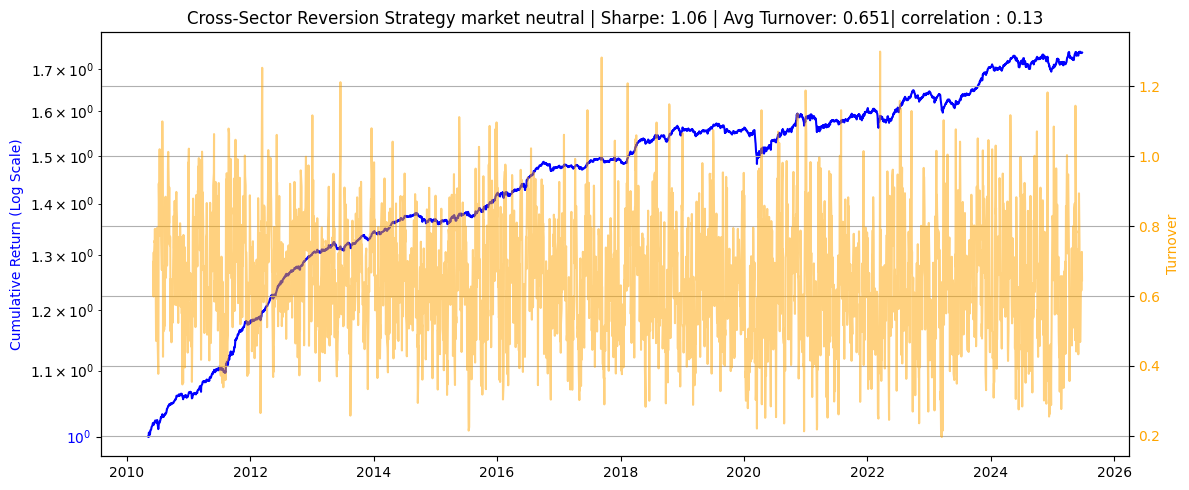

In [ ]:
(long_weights,short_weights,weights,strategy_returns) = backtest(df_rets, market_residuals,market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = True, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 40, beta_hedge=False, rolling_window = False, rolling_window_size=4, beta_neutralize= True, w_nue=w_proj)

In [ ]:
|